# Comprehensive Constraints Analysis - With Removed Statements - Final

In this notebook, the original dataset is combined with the removed statements dataset and then the violations are determined in total.

In [2]:
# Split claims file into multiple files
import gzip
from tqdm.notebook import tqdm
propFileDict = {}
fileLineCount = 1225057250
with open('../../data/claims.w_removed_statements.tsv','r') as fin: 
    headerLine = next(fin)
    for line in tqdm(fin, total = fileLineCount):
        lineP = line.rstrip().split("\t")
        if "external-id" in lineP[-1]:
            continue
        prop = lineP[2]
        if prop not in propFileDict:
            propFileDict[prop] = open("../../propertiesSplit_WRemoved_Final/claims."+str(prop)+".tsv","w")
            propFileDict[prop].write(headerLine)
        propFileDict[prop].write(line)
    for file1 in propFileDict.values():
        file1.close()

  0%|          | 0/1149471184 [00:00<?, ?it/s]

# Generate Queries

## Type Constraint

Type constraint indicates that node1 must be an instance of or subclass of the class specified.

### Understand Constraints File

In [ ]:
import pandas as pd
df = pd.read_csv('../../constraintsOP/typeConstraint/claims.type-constraints_all.tsv',sep='\t')

In [ ]:
df1 = df.groupby(['node1','label']).node2.apply(lambda p: p.tolist()).reset_index()

In [ ]:
df1.head()

In [ ]:
df1[df1['node1'] == 'P8138']

### Query Generator

In [ ]:
from tqdm.notebook import tqdm
import os.path
import os

cnt = 0
fCnt = 1

fOP = None

for prop in tqdm(df1.node1.unique()):
    try:
        if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv")):
            continue
        relation = df1[(df1['node1'] == prop) & (df1['label'] == 'P2309')].node2.values[0][0]
        type1 = df1[(df1['node1'] == prop) & (df1['label'] == 'P2316')].node2.values
#         print(type1)

        parents = df1[(df1['node1'] == prop) & (df1['label'] == 'P2308')].node2.values[0]
        exceptions = df1[(df1['node1'] == prop) & (df1['label'] == 'P2303')].node2.values
        
        if relation == "Q21503252":
            parentFile = "P31"
            parentTitle = 'instanceOf'
        elif relation == "Q21514624":
            parentFile = "P279"
            parentTitle = 'subclass'
        else:
            parentFile = "isa"
            parentTitle = 'instanceOfOrSubclass'

        if len(type1) != 0 and type1[0][0] == "Q21502408":
            typeVal = "mandatory"
        elif len(type1) != 0 and type1[0][0] == "Q62026391":
            typeVal = "suggestion"
        else:
            typeVal = "normal"

        if len(exceptions):
            exceptionPart = "or node1 in " + str(exceptions[0]).replace("'",'"')
        else:
            exceptionPart = ""
        
        folderName = 'typeConstraint'
        shellFileSuffix = 'typeConstraintValidator'
        
        if cnt % 120 == 0:
            if fOP:
                fOP.close()
            fOP = open("../../propertiesSplit_WRemoved_Final/checkViolations/" + shellFileSuffix + str(fCnt) + ".sh","w")
            fCnt += 1
        
        fOP.write("{ time (kgtk --debug query -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
        ../../wikidata-20210215/derived." + parentFile + ".tsv.gz \
        ../../wikidata-20210215/derived.P279star.tsv.gz \
        --match 'm: (node1)-[nodeProp]->(node2), " + parentFile + ": (node1)-[]->(nodex), P279star: (nodex)-[]->(par)' \
        --where 'par in " + str(parents).replace("'",'"') + " " + exceptionPart + "' \
        --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`' \
        -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp.tsv \
        --graph-cache ~/sqlite3_caches/type_new2_" + str(fCnt) + ".sqlite3.db; \
         kgtk --debug ifnotexists -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
        --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp.tsv \
        -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".incorrect_temp.tsv ;\
        kgtk --debug query -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".incorrect_temp.tsv \
        ../../wikidata-20210215/derived." + parentFile + ".tsv.gz \
        --match 'm: (node1)-[nodeProp]->(node2), " + parentFile + ": (node1)-[]->(par)' \
        --where 'par in " + str(parents).replace("'",'"') + " " + exceptionPart + "' \
        --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`' \
        -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp2.tsv \
        --graph-cache ~/sqlite3_caches/type_new2_" + str(fCnt) + ".sqlite3.db; \
         kgtk --debug ifnotexists -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".incorrect_temp.tsv \
        --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp2.tsv \
        -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".incorrect.tsv ; \
         kgtk --debug cat -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp.tsv \
        ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp2.tsv \
        -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct.tsv ; \
        ) } 2>> ../../propertiesSplit_WRemoved_Final/checkViolations/exec_logs/" + shellFileSuffix + str(fCnt) + ".txt;\n")

        cnt += 1
    except:
        print("Something failed for prop:",prop)

if fOP:
    fOP.close()

In [ ]:
cnt

In [72]:
# import os
# for i in range(1,14):
#     os.system("screen -dm sh ../../propertiesSplit_WRemoved_Final/checkViolations/typeConstraintValidator"+str(i)+".sh")
    

### Analyze Violations

In [21]:
import pandas as pd
import os
from tqdm.notebook import tqdm

typeConstViolations = {}

def countLines(fname):
    cnt = -1
    with open(fname, 'r') as f:
        for line in f:
            cnt += 1
    return cnt

propList = set()

violations = {}

for folder in tqdm(iter(['mandatory', 'suggestion', 'normal'])):
    typeConstViolations[folder] = {'instanceOf': {'correct': 0, 'incorrect': 0}, 'subclass': {'correct': 0, 'incorrect': 0}, 'instanceOfOrSubclass': {'correct': 0, 'incorrect': 0},'propCount': 0}
    filePath = "../../allConstraintsAnalysis_WRemoved_Final/typeConstraint/"+folder+"/"
    for filename in tqdm(os.listdir(filePath)):
        type1 = filename.split(".")[2]
        prop = filename.split(".")[3]
        propList.add(prop)
        correctness = filename.split(".")[4]
        count1 = countLines(filePath+filename)
        if correctness not in ['correct','incorrect']:
            continue
        typeConstViolations[folder][type1][correctness] += count1
        if prop not in violations:
            violations[prop] = {'correct': 0, 'incorrect': 0, 'paths': []}
        violations[prop][correctness] = count1
        violations[prop]['paths'].append(filePath+filename)
        if correctness == 'correct':
            typeConstViolations[folder]['propCount'] += 1
        

0it [00:00, ?it/s]

  0%|          | 0/835 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/6435 [00:00<?, ?it/s]

In [23]:
recordCount = 0
for elem in typeConstViolations.keys():
    for key1 in typeConstViolations[elem].keys():
        try:
            recordCount += typeConstViolations[elem][key1]['correct'] + typeConstViolations[elem][key1]['incorrect']
        except:
            continue
print(f"{len(propList)} properties processed for type constraint for {recordCount} statements")

1465 properties processed for type constraint for 550605745 statements


In [24]:
import pandas as pd
typeConstDF = pd.DataFrame(violations).T

In [25]:
typeConstDF['violation_ratio'] = typeConstDF.apply(lambda p: p.incorrect / (p.correct + p.incorrect), axis=1)

In [26]:
typeConstDF.head()

correct incorrect                                              paths  \
P1303  203148      2610  [../../allConstraintsAnalysis_WRemoved_Final/t...   
P3919    3393       158  [../../allConstraintsAnalysis_WRemoved_Final/t...   
P6185     269        12  [../../allConstraintsAnalysis_WRemoved_Final/t...   
P3922    1824        51  [../../allConstraintsAnalysis_WRemoved_Final/t...   
P301   705949     28017  [../../allConstraintsAnalysis_WRemoved_Final/t...   

       violation_ratio  
P1303         0.012685  
P3919         0.044495  
P6185         0.042705  
P3922         0.027200  
P301          0.038172

In [27]:
typeConstDF.sort_values(by=['violation_ratio','incorrect'],ascending=False).head(15)

correct incorrect                                              paths  \
P8138       0       462  [../../allConstraintsAnalysis_WRemoved_Final/t...   
P5051       0        81  [../../allConstraintsAnalysis_WRemoved_Final/t...   
P2309       0        55  [../../allConstraintsAnalysis_WRemoved_Final/t...   
P2308       0        51  [../../allConstraintsAnalysis_WRemoved_Final/t...   
P2303       0        44  [../../allConstraintsAnalysis_WRemoved_Final/t...   
P1227       0        20  [../../allConstraintsAnalysis_WRemoved_Final/t...   
P2912       0        16  [../../allConstraintsAnalysis_WRemoved_Final/t...   
P6001       0        16  [../../allConstraintsAnalysis_WRemoved_Final/t...   
P8738       0        14  [../../allConstraintsAnalysis_WRemoved_Final/t...   
P538        0        10  [../../allConstraintsAnalysis_WRemoved_Final/t...   
P8004       0         6  [../../allConstraintsAnalysis_WRemoved_Final/t...   
P5589       0         5  [../../allConstraintsAnalysis_WRemoved_Final/t...   
P2312       0         5  [../../allConstraintsAnalysis_WRemoved_Final/t...   
P6510       0         4  [../../allConstraintsAnalysis_WRemoved_Final/t...   
P2310       0         4  [../../allConstraintsAnalysis_WRemoved_Final/t...   

       violation_ratio  
P8138              1.0  
P5051              1.0  
P2309              1.0  
P2308              1.0  
P2303              1.0  
P1227              1.0  
P2912              1.0  
P6001              1.0  
P8738              1.0  
P538               1.0  
P8004              1.0  
P5589              1.0  
P2312              1.0  
P6510              1.0  
P2310              1.0

In [30]:
typeConstDF['violation_ratio'].describe()

count    1465.000000
mean        0.117857
std         0.226919
min         0.000000
25%         0.007233
50%         0.024422
75%         0.094675
max         1.000000
Name: violation_ratio, dtype: float64

Text(0.5, 1.0, 'Type Constraint Violation Ratios')

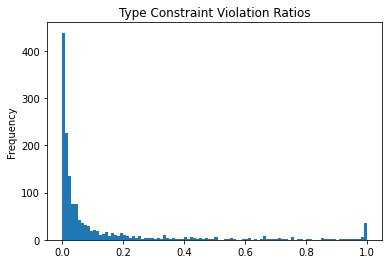

In [31]:
typeConstDF['violation_ratio'].plot.hist(bins=100).set_title("Type Constraint Violation Ratios")

Text(0.5, 1.0, 'Type Constraint Violation Ratios (<=0.05)')

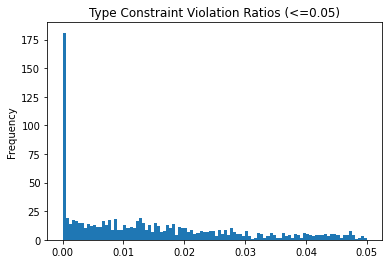

In [32]:
typeConstDF[typeConstDF['violation_ratio'] <= 0.05].violation_ratio.plot.hist(bins=100).set_title("Type Constraint Violation Ratios (<=0.05)")

In [33]:
print(f"No. of constraints whose violation ratio is greater than mean :{sum(typeConstDF['violation_ratio'] >= 5.286054)}/{len(typeConstDF)}")

No. of constraints whose violation ratio is greater than mean :0/1465


In [36]:
for key1 in typeConstViolations.keys():
    typeConstViolations[key1]['correct'] = typeConstViolations[key1]['instanceOf']['correct'] + typeConstViolations[key1]['subclass']['correct'] + typeConstViolations[key1]['instanceOfOrSubclass']['correct']
    typeConstViolations[key1]['incorrect'] = typeConstViolations[key1]['instanceOf']['incorrect'] + typeConstViolations[key1]['subclass']['incorrect'] + typeConstViolations[key1]['instanceOfOrSubclass']['incorrect']
    typeConstViolations[key1]['VR'] = typeConstViolations[key1]['incorrect'] / (typeConstViolations[key1]['correct'] + typeConstViolations[key1]['incorrect'])
        

In [37]:
typeConstViolations

{'mandatory': {'instanceOf': {'correct': 46306630, 'incorrect': 798106},
  'subclass': {'correct': 2064, 'incorrect': 53},
  'instanceOfOrSubclass': {'correct': 233195, 'incorrect': 3169},
  'propCount': 167,
  'correct': 46541889,
  'incorrect': 801328,
  'VR': 0.016925930487571218},
 'suggestion': {'instanceOf': {'correct': 62170, 'incorrect': 19110},
  'subclass': {'correct': 0, 'incorrect': 0},
  'instanceOfOrSubclass': {'correct': 24237, 'incorrect': 3458},
  'propCount': 11,
  'correct': 86407,
  'incorrect': 22568,
  'VR': 0.20709337003899977},
 'normal': {'instanceOf': {'correct': 425791059, 'incorrect': 7991316},
  'subclass': {'correct': 98826, 'incorrect': 13672},
  'instanceOfOrSubclass': {'correct': 68383205, 'incorrect': 875475},
  'propCount': 1287,
  'correct': 494273090,
  'incorrect': 8880463,
  'VR': 0.017649608051162863}}

In [38]:
typeConstDF['total'] = typeConstDF['correct'] + typeConstDF['incorrect']
typeConstDF.sort_values(by=['total'],ascending=False).head()

correct incorrect                                              paths  \
P2093  148843213   1512369  [../../allConstraintsAnalysis_WRemoved_Final/t...   
P1476   44100871   2199197  [../../allConstraintsAnalysis_WRemoved_Final/t...   
P577    39990807    165864  [../../allConstraintsAnalysis_WRemoved_Final/t...   
P1433   37028672    112955  [../../allConstraintsAnalysis_WRemoved_Final/t...   
P1215   33425605    316565  [../../allConstraintsAnalysis_WRemoved_Final/t...   

       violation_ratio      total  
P2093         0.010059  150355582  
P1476         0.047499   46300068  
P577          0.004130   40156671  
P1433         0.003041   37141627  
P1215         0.009382   33742170

In [39]:
typeConstDF.to_csv('../../allConstraintsAnalysis_WRemoved_Final/typeConstDFAnalysis.csv')

### Find out time required

In [ ]:
import pandas as pd
import os
from tqdm.notebook import tqdm

codepConstViolations = {}

codepConstViolations = {}
codepConstPropList = set()

def extractTimes(filename):
    times = []
    with open(filename) as f:
        for line in f:
            if "real" in line:
                line = line.strip()
                time1 = line.split("\t")[1]
                mins, sec = time1.split("m")
                mins = int(mins)
                sec = float(sec[:-1])
                times.append(60 * mins + sec)
    return times

# codepConstViolationsSummary = {}
times = []
filePath = '/data/wd-correctness/propertiesSplit_WRemoved_Final/checkViolations/exec_logs/'
for filename in tqdm(os.listdir(filePath)):
    if filename.startswith("typeConstraintValidator"):
        tempTimes = extractTimes(filePath + filename)
        times += tempTimes

In [ ]:
print(pd.Series(times).describe())

In [ ]:
import seaborn as sns
sns.lineplot(data=pd.Series(times)).set_title("Distribution of times (in s) taken for type constraint checks")

## Value Type Constraint

Here, the constraint indicates that node2 must be an instance of or subclass of the specified class

### Understand Constraints File

In [ ]:
import pandas as pd
dfValueType = pd.read_csv('../../constraintsOP/valuetypeConstraint/claims.type-constraints_all1.tsv',sep='\t')

In [ ]:
dfValueType = dfValueType.groupby(['node1','label']).node2.apply(lambda p: p.tolist()).reset_index()

In [ ]:
dfValueType.head()

In [ ]:
dfValueType['label'].unique()

### Query Generator

In [43]:
from tqdm.notebook import tqdm
import os.path
import os

cnt = 0
fCnt = 1

fOP = None

for prop in tqdm(dfValueType.node1.unique()):
    try:
        if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv")):
            continue
        relation = dfValueType[(dfValueType['node1'] == prop) & (dfValueType['label'] == 'P2309')].node2.values[0][0]
        type1 = dfValueType[(dfValueType['node1'] == prop) & (dfValueType['label'] == 'P2316')].node2.values
#         print(type1)

        parents = dfValueType[(dfValueType['node1'] == prop) & (dfValueType['label'] == 'P2308')].node2.values[0]
        exceptions = dfValueType[(dfValueType['node1'] == prop) & (dfValueType['label'] == 'P2303')].node2.values
        
        if relation == "Q21503252":
            parentFile = "P31"
            parentTitle = 'instanceOf'
        elif relation == "Q21514624":
            parentFile = "P279"
            parentTitle = 'subclass'
        else:
            parentFile = "isa"
            parentTitle = 'instanceOfOrSubclass'

        if len(type1) != 0 and type1[0][0] == "Q21502408":
            typeVal = "mandatory"
        elif len(type1) != 0 and type1[0][0] == "Q62026391":
            typeVal = "suggestion"
        else:
            typeVal = "normal"

        if len(exceptions):
            exceptionPart = "or node2 in " + str(exceptions[0]).replace("'",'"')
        else:
            exceptionPart = ""
        
        folderName = 'valueTypeConstraint'
        shellFileSuffix = 'valueTypeConstraintValidator'
        
        if cnt % 120 == 0:
            if fOP:
                fOP.close()
            fOP = open("../../propertiesSplit_WRemoved_Final/checkViolations/" + shellFileSuffix + str(fCnt) + ".sh","w")
            fCnt += 1
        
        fOP.write("{ time (kgtk --debug query -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
        ../../wikidata-20210215/derived." + parentFile + ".tsv.gz \
        ../../wikidata-20210215/derived.P279star.tsv.gz \
        --match 'm: (node1)-[nodeProp]->(node2), " + parentFile + ": (node2)-[]->(nodex), P279star: (nodex)-[]->(par)' \
        --where 'par in " + str(parents).replace("'",'"') + " " + exceptionPart + "' \
        --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`' \
        -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp.tsv \
        --graph-cache ~/sqlite3_caches/valueType_new_" + str(fCnt) + ".sqlite3.db; \
         kgtk --debug ifnotexists -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
        --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp.tsv \
        -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".incorrect_temp.tsv ;\
        kgtk --debug query -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".incorrect_temp.tsv \
        ../../wikidata-20210215/derived." + parentFile + ".tsv.gz \
        --match 'm: (node1)-[nodeProp]->(node2), " + parentFile + ": (node2)-[]->(par)' \
        --where 'par in " + str(parents).replace("'",'"') + " " + exceptionPart + "' \
        --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`' \
        -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp2.tsv \
        --graph-cache ~/sqlite3_caches/valueType_new_" + str(fCnt) + ".sqlite3.db; \
         kgtk --debug ifnotexists -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".incorrect_temp.tsv \
        --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp2.tsv \
        -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".incorrect.tsv ; \
         kgtk --debug cat -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp.tsv \
        ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct_temp2.tsv \
        -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + typeVal + "/claims.type-constraints." + parentTitle + "."+ prop +".correct.tsv ; \
        ) } 2>> ../../propertiesSplit_WRemoved_Final/checkViolations/exec_logs/" + shellFileSuffix + str(fCnt) + ".txt;\n")

        cnt += 1
    except:
        print("Something failed for prop:",prop)

if fOP:
    fOP.close()

  0%|          | 0/932 [00:00<?, ?it/s]

Something failed for prop: P1389


In [3]:
!zgrep -P "Q98970042\t" ../../wikidata-20210215/derived.P279star.tsv.gz

In [44]:
cnt

897

In [45]:
# import os
# for i in range(1,9):
#     os.system("screen -dm sh ../../propertiesSplit_WRemoved_Final/checkViolations/valueTypeConstraintValidator_xverify3"+str(i)+".sh")
    

### Analyze Violations

In [41]:
import pandas as pd
import os
from tqdm.notebook import tqdm

valueTypeConstViolations = {}

def countLines(fname):
    cnt = -1
    with open(fname, 'r') as f:
        for line in f:
            cnt += 1
    return cnt

valueTypePropList = set()

violations = {}

for folder in tqdm(iter(['mandatory', 'suggestion', 'normal'])):
    valueTypeConstViolations[folder] = {'instanceOf': {'correct': 0, 'incorrect': 0}, 'subclass': {'correct': 0, 'incorrect': 0}, 'instanceOfOrSubclass': {'correct': 0, 'incorrect': 0}, 'propCount':0}
    filePath = "../../allConstraintsAnalysis_WRemoved_Final/valueTypeConstraint/"+folder+"/"
    for filename in tqdm(os.listdir(filePath)):
        type1 = filename.split(".")[2]
        prop = filename.split(".")[3]
        valueTypePropList.add(prop)
        correctness = filename.split(".")[4]
        count1 = countLines(filePath+filename)
        if correctness not in ['correct','incorrect']:
            continue
        valueTypeConstViolations[folder][type1][correctness] += count1
        if prop not in violations:
            violations[prop] = {'correct': 0, 'incorrect': 0, 'paths': []}
        violations[prop][correctness] = count1
        violations[prop]['paths'].append(filePath+filename)
        if correctness == 'correct':
            valueTypeConstViolations[folder]['propCount'] += 1
        

0it [00:00, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3955 [00:00<?, ?it/s]

In [43]:
recordCount = 0
for elem in valueTypeConstViolations.keys():
    for key1 in valueTypeConstViolations[elem].keys():
        try:
            recordCount += valueTypeConstViolations[elem][key1]['correct'] + valueTypeConstViolations[elem][key1]['incorrect']
        except:
            continue
print(f"{len(valueTypePropList)} properties processed for value type constraint for {recordCount} statements")

904 properties processed for value type constraint for 191291040 statements


In [44]:
import pandas as pd
valTypeConstDF = pd.DataFrame(violations).T

In [45]:
valTypeConstDF['violation_ratio'] = valTypeConstDF.apply(lambda p: p.incorrect / (p.incorrect + p.correct), axis=1)

In [46]:
valTypeConstDF.head()

correct incorrect                                              paths  \
P852     4526        24  [../../allConstraintsAnalysis_WRemoved_Final/v...   
P2363    4404         0  [../../allConstraintsAnalysis_WRemoved_Final/v...   
P7327     187         6  [../../allConstraintsAnalysis_WRemoved_Final/v...   
P853     1600         8  [../../allConstraintsAnalysis_WRemoved_Final/v...   
P2302   47918        35  [../../allConstraintsAnalysis_WRemoved_Final/v...   

       violation_ratio  
P852          0.005275  
P2363         0.000000  
P7327         0.031088  
P853          0.004975  
P2302         0.000730

In [47]:
valTypeConstDF.sort_values(by=['violation_ratio','incorrect'],ascending=False).head(15)

correct incorrect                                              paths  \
P5008       0    341961  [../../allConstraintsAnalysis_WRemoved_Final/v...   
P6104       0      9808  [../../allConstraintsAnalysis_WRemoved_Final/v...   
P7374       0        44  [../../allConstraintsAnalysis_WRemoved_Final/v...   
P3028       0        15  [../../allConstraintsAnalysis_WRemoved_Final/v...   
P2839       0        15  [../../allConstraintsAnalysis_WRemoved_Final/v...   
P3027       0        13  [../../allConstraintsAnalysis_WRemoved_Final/v...   
P538        0        10  [../../allConstraintsAnalysis_WRemoved_Final/v...   
P2241       0         6  [../../allConstraintsAnalysis_WRemoved_Final/v...   
P4425       0         6  [../../allConstraintsAnalysis_WRemoved_Final/v...   
P6191       0         5  [../../allConstraintsAnalysis_WRemoved_Final/v...   
P6533       0         5  [../../allConstraintsAnalysis_WRemoved_Final/v...   
P6534       0         5  [../../allConstraintsAnalysis_WRemoved_Final/v...   
P660        0         4  [../../allConstraintsAnalysis_WRemoved_Final/v...   
P7174       0         3  [../../allConstraintsAnalysis_WRemoved_Final/v...   
P8627       0         2  [../../allConstraintsAnalysis_WRemoved_Final/v...   

       violation_ratio  
P5008              1.0  
P6104              1.0  
P7374              1.0  
P3028              1.0  
P2839              1.0  
P3027              1.0  
P538               1.0  
P2241              1.0  
P4425              1.0  
P6191              1.0  
P6533              1.0  
P6534              1.0  
P660               1.0  
P7174              1.0  
P8627              1.0

In [49]:
valTypeConstDF['violation_ratio'].describe()

count    904.000000
mean       0.112995
std        0.211926
min        0.000000
25%        0.006362
50%        0.024834
75%        0.099675
max        1.000000
Name: violation_ratio, dtype: float64

Text(0.5, 1.0, 'Value Type Constraint Violation Ratios')

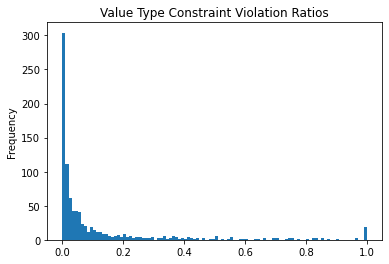

In [50]:
valTypeConstDF['violation_ratio'].plot.hist(bins=100).set_title("Value Type Constraint Violation Ratios")

Text(0.5, 1.0, 'Value Type Constraint Violation Ratios (<=0.04)')

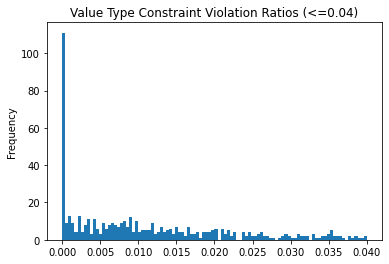

In [51]:
valTypeConstDF[valTypeConstDF['violation_ratio'] <= 0.04].violation_ratio.plot.hist(bins=100).set_title("Value Type Constraint Violation Ratios (<=0.04)")

In [52]:
print(f"No. of constraints whose violation ratio is greater than mean :{sum(valTypeConstDF['violation_ratio'] >= 3.950680)}/{len(valTypeConstDF)}")

No. of constraints whose violation ratio is greater than mean :0/904


In [55]:
for key1 in valueTypeConstViolations.keys():
    valueTypeConstViolations[key1]['correct'] = valueTypeConstViolations[key1]['instanceOf']['correct'] + valueTypeConstViolations[key1]['subclass']['correct'] + valueTypeConstViolations[key1]['instanceOfOrSubclass']['correct']
    valueTypeConstViolations[key1]['incorrect'] = valueTypeConstViolations[key1]['instanceOf']['incorrect'] + valueTypeConstViolations[key1]['subclass']['incorrect'] + valueTypeConstViolations[key1]['instanceOfOrSubclass']['incorrect']
    valueTypeConstViolations[key1]['VR'] = valueTypeConstViolations[key1]['incorrect'] / (valueTypeConstViolations[key1]['correct'] + valueTypeConstViolations[key1]['incorrect'])
        

In [56]:
valueTypeConstViolations

{'mandatory': {'instanceOf': {'correct': 11564885, 'incorrect': 30391},
  'subclass': {'correct': 55983, 'incorrect': 83},
  'instanceOfOrSubclass': {'correct': 13090, 'incorrect': 320},
  'propCount': 108,
  'correct': 11633958,
  'incorrect': 30794,
  'VR': 0.0026399189627006217},
 'suggestion': {'instanceOf': {'correct': 46189, 'incorrect': 715},
  'subclass': {'correct': 127, 'incorrect': 32},
  'instanceOfOrSubclass': {'correct': 0, 'incorrect': 0},
  'propCount': 5,
  'correct': 46316,
  'incorrect': 747,
  'VR': 0.01587234132970699},
 'normal': {'instanceOf': {'correct': 94116782, 'incorrect': 2067912},
  'subclass': {'correct': 4674914, 'incorrect': 73885},
  'instanceOfOrSubclass': {'correct': 77686563, 'incorrect': 959169},
  'propCount': 791,
  'correct': 176478259,
  'incorrect': 3100966,
  'VR': 0.01726795513233783}}

In [57]:
valTypeConstDF.to_csv('../../allConstraintsAnalysis_WRemoved_Final/valueTypeConstDFAnalysis.csv')

### Find out time required

In [ ]:
import pandas as pd
import os
from tqdm.notebook import tqdm

codepConstViolations = {}

codepConstViolations = {}
codepConstPropList = set()

def extractTimes(filename):
    times = []
    with open(filename) as f:
        for line in f:
            if "real" in line:
                line = line.strip()
                time1 = line.split("\t")[1]
                mins, sec = time1.split("m")
                mins = int(mins)
                sec = float(sec[:-1])
                times.append(60 * mins + sec)
    return times

# codepConstViolationsSummary = {}
times = []
filePath = '/data/wd-correctness/propertiesSplit_WRemoved_Final/checkViolations/exec_logs/'
for filename in tqdm(os.listdir(filePath)):
    if filename.startswith("valueTypeConstraintValidator"):
        tempTimes = extractTimes(filePath + filename)
        times += tempTimes

In [ ]:
print(pd.Series(times).describe())

In [ ]:
import seaborn as sns
sns.lineplot(data=pd.Series(times)).set_title("Distribution of times (in s) taken for value type constraint checks")

## Item Requires Statement Constraint

Here, the constraint mentions the other properties that node1 must have and the values that this property must have in few cases

### Understand Constraints File

In [58]:
import pandas as pd
import math
dfItemRequires = pd.read_csv('../../constraintsOP/itemRequiresConstraint/claims.type-constraints_all.tsv',sep='\t')

In [59]:
dfItemRequires = dfItemRequires.groupby(['id','node1','label']).node2.apply(lambda p: p.tolist()).reset_index()

In [60]:
dfItemRequires['label'].unique()

array(['P2306', 'P2305', 'P2316', 'P2304', 'P2303', 'P6607', 'P4155',
       'P31', 'P2916', 'P4680', 'P2308'], dtype=object)

In [61]:
dfItemRequires['label'].value_counts()

P2306    7182
P2305    2540
P2316    2523
P2303     422
P2304      14
P6607      14
P2916       5
P4680       2
P4155       1
P31         1
P2308       1
Name: label, dtype: int64

In [62]:
#Reference: https://stackoverflow.com/a/17298454
dfItemRequires = dfItemRequires.pivot(index=['node1','id'], columns='label', values='node2')

In [63]:
dfItemRequires.head()

label                                  P2303 P2304   P2305   P2306 P2308  \
node1 id                                                                   
P1006 P1006-P2302-Q21503247-0451ef47-0   NaN   NaN     NaN  [P214]   NaN   
P1010 P1010-P2302-Q21503247-56183614-0   NaN   NaN     NaN   [P31]   NaN   
      P1010-P2302-Q21503247-fd256eaf-0   NaN   NaN  [Q794]   [P17]   NaN   
P1015 P1015-P2302-Q21503247-20e3bfc5-0   NaN   NaN     NaN   [P31]   NaN   
P1017 P1017-P2302-Q21503247-bbac2ce3-0   NaN   NaN     NaN  [P214]   NaN   

label                                         P2316 P2916  P31 P4155 P4680  \
node1 id                                                                     
P1006 P1006-P2302-Q21503247-0451ef47-0          NaN   NaN  NaN   NaN   NaN   
P1010 P1010-P2302-Q21503247-56183614-0          NaN   NaN  NaN   NaN   NaN   
      P1010-P2302-Q21503247-fd256eaf-0  [Q21502408]   NaN  NaN   NaN   NaN   
P1015 P1015-P2302-Q21503247-20e3bfc5-0          NaN   NaN  NaN   NaN   NaN   
P1017 P1017-P2302-Q21503247-bbac2ce3-0          NaN   NaN  NaN   NaN   NaN   

label                                  P6607  
node1 id                                      
P1006 P1006-P2302-Q21503247-0451ef47-0   NaN  
P1010 P1010-P2302-Q21503247-56183614-0   NaN  
      P1010-P2302-Q21503247-fd256eaf-0   NaN  
P1015 P1015-P2302-Q21503247-20e3bfc5-0   NaN  
P1017 P1017-P2302-Q21503247-bbac2ce3-0   NaN

In [64]:
dfItemRequires = dfItemRequires.droplevel(1)

In [65]:
dfItemRequires.head()

label P2303 P2304   P2305   P2306 P2308        P2316 P2916  P31 P4155 P4680  \
node1                                                                         
P1006   NaN   NaN     NaN  [P214]   NaN          NaN   NaN  NaN   NaN   NaN   
P1010   NaN   NaN     NaN   [P31]   NaN          NaN   NaN  NaN   NaN   NaN   
P1010   NaN   NaN  [Q794]   [P17]   NaN  [Q21502408]   NaN  NaN   NaN   NaN   
P1015   NaN   NaN     NaN   [P31]   NaN          NaN   NaN  NaN   NaN   NaN   
P1017   NaN   NaN     NaN  [P214]   NaN          NaN   NaN  NaN   NaN   NaN   

label P6607  
node1        
P1006   NaN  
P1010   NaN  
P1010   NaN  
P1015   NaN  
P1017   NaN

However, there is one anomaly where the property does not have a co-dependency constraint associated with it, but still has a link to this constraint.

In [66]:
dfItemRequires[dfItemRequires['P4680'].apply(lambda p: type(p) == list)]

label P2303 P2304        P2305    P2306 P2308 P2316 P2916  P31 P4155  \
node1                                                                  
P5447   NaN   NaN  [Q55426051]  [P5446]   NaN   NaN   NaN  NaN   NaN   
P5448   NaN   NaN  [Q55426051]  [P5446]   NaN   NaN   NaN  NaN   NaN   

label        P4680 P6607  
node1                     
P5447  [Q46466783]   NaN  
P5448  [Q46466783]   NaN

In [67]:
dfItemRequires[dfItemRequires['P2305'].apply(lambda p: type(p) == list)]

label              P2303 P2304                             P2305   P2306  \
node1                                                                      
P1010                NaN   NaN                            [Q794]   [P17]   
P1045                NaN   NaN  [Q20808382, Q28218485, Q3044918]   [P39]   
P1045                NaN   NaN                          [Q82955]  [P106]   
P1045                NaN   NaN                              [Q5]   [P31]   
P1045                NaN   NaN                    [Q142, Q71084]   [P27]   
...                  ...   ...                               ...     ...   
P980                 NaN   NaN                             [Q34]   [P17]   
P981                 NaN   NaN                             [Q55]   [P17]   
P981                 NaN   NaN                        [Q1852859]   [P31]   
P988                 NaN   NaN                            [Q928]   [P17]   
P990   [Q49678, Q853715]   NaN                              [Q5]   [P31]   

label P2308        P2316 P2916  P31 P4155 P4680 P6607  
node1                                                  
P1010   NaN  [Q21502408]   NaN  NaN   NaN   NaN   NaN  
P1045   NaN          NaN   NaN  NaN   NaN   NaN   NaN  
P1045   NaN          NaN   NaN  NaN   NaN   NaN   NaN  
P1045   NaN  [Q21502408]   NaN  NaN   NaN   NaN   NaN  
P1045   NaN          NaN   NaN  NaN   NaN   NaN   NaN  
...     ...          ...   ...  ...   ...   ...   ...  
P980    NaN  [Q21502408]   NaN  NaN   NaN   NaN   NaN  
P981    NaN  [Q21502408]   NaN  NaN   NaN   NaN   NaN  
P981    NaN          NaN   NaN  NaN   NaN   NaN   NaN  
P988    NaN  [Q21502408]   NaN  NaN   NaN   NaN   NaN  
P990    NaN          NaN   NaN  NaN   NaN   NaN   NaN  

[2540 rows x 11 columns]

### Query Generator

#### Version 1 - Mandatory + Suggestion + Normal

In [11]:
from tqdm.notebook import tqdm
import os.path
import os

cnt = 0
fCnt = 0

fOP = None

folderName = 'codependencyConstraint'
subFolderName = "Mand_Sugg_Normal"
shellFileSuffix = 'codepConst_MSN_Validator'
graph_cache_file_prefix = "cache_new_11_"

for prop in tqdm(dfItemRequires.index.unique()):
#     try:
        mandatory = []
        suggestion = []
        normal = []
        prop = str(prop)
        
        for _, constraint in dfItemRequires.loc[[prop]].iterrows():
            if type(constraint['P2316']) == list:
                if constraint['P2316'][0] == 'Q21502408':
                    mandatory.append(constraint)
                elif constraint['P2316'][0] == 'Q62026391':
                    suggestion.append(constraint)
            else:
                normal.append(constraint)
        
        if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv")):
            continue
                
        commandInit = "{ time ( kgtk --debug query -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv "
        commandOtherFiles = ""
        commandMatch = "--match '"
        commandMatchMoreFiles = [f"{prop}: (node1)-[nodeProp]->(node2)"]
        commandWhere = " --where '"
        commandWhere = []
        
        # Version 1 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        constSet = mandatory + suggestion + normal
        
        if len(constSet) == 0:
            continue
        excptns = set()
        for (rowNo, constraint) in enumerate(constSet):
            prop2 = constraint['P2306']
            
            if type(prop2) != list:
                continue
            prop2 = prop2[0]
                
            if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop2 +".tsv")):
                print(f"File: ../../propertiesSplit_WRemoved_Final/claims.{prop2}.tsv does not exist")
                continue
            
            commandOtherFiles += "../../propertiesSplit_WRemoved_Final/claims."+ prop2 +".tsv "
            if type(constraint['P2303']) == list: # Exceptions present
                if len(excptns) == 0:
                    excptns = set(constraint['P2303'])
                else:
                    excptns = excptns.intersection(set(constraint['P2303']))
            if type(constraint['P2305']) == list:
                commandMatchMoreFiles += [f"{prop2}: (node1)-[]->(node2_{prop2})"]
                commandWhere += ["node2_" + prop2 + " in " + str(list(constraint['P2305'])).replace("'",'"')]
            else:
                commandMatchMoreFiles += [f"{prop2}: (node1)-[]->()"]
#         print(commandMatchMoreFiles)
        if len(commandWhere) == 0:
            command = commandInit + commandOtherFiles + commandMatch + (", ".join(commandMatchMoreFiles)) + "'"
        else:
            command = commandInit + commandOtherFiles + commandMatch + (", ".join(commandMatchMoreFiles)) + "'" + " --where '"+(" and ".join(commandWhere))+"'"
        
        if cnt % 60 == 0:
            if fOP:
                fOP.close()
            fCnt += 1
            fOP = open("../../propertiesSplit_WRemoved_Final/checkViolations/" + shellFileSuffix + str(fCnt) + ".sh","w")
        
        if len(excptns) == 0:
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv \
            --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect.tsv ) } 2>> ../../propertiesSplit_WRemoved_Final/checkViolations/exec_logs/timeLog_" + shellFileSuffix + str(fCnt) + ".txt;\n"
            fOP.write(command)
        else:
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
            --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect_wo_exceptions.tsv\n"
            fOP.write(command)
            
            command = "  kgtk --debug query -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
                    --match '(node1)-[]->()' --where 'node1 in " + str(list(excptns)).replace("'",'"') + "' \
                    -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv \
                    --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; "
            fOP.write(command)
            
            command = "  kgtk --debug ifnotexists -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect.tsv; "
            fOP.write(command)
            
            command = "  kgtk cat -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
                    ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect_w_exceptions.tsv \
                    -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv ) } 2>> ../../propertiesSplit_WRemoved_Final/checkViolations/exec_logs/timeLog_" + shellFileSuffix + str(fCnt) + ".txt; \n"
            fOP.write(command)
        
        
        cnt += 1
#     except:
#         print("Something failed for prop:",prop)
if fOP:
    fOP.close()

  0%|          | 0/3147 [00:00<?, ?it/s]

File: ../../propertiesSplit_WRemoved_Final/claims.P345.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P2604.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1566.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1566.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P2355.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P3350.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1014.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P2636.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1771.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P2755.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P8326.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P5128.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1627.tsv does not exist
File: ../../propertiesSpli

In [12]:
cnt

534

In [13]:
fCnt

9

In [54]:
# import os
# for i in range(1,28):
#     os.system("screen -dm sh ../../propertiesSplit_WRemoved_Final/checkViolations/codepConst_MSN_Validator"+str(i)+".sh")

#### Version 2 - Mandatory + Normal

In [15]:
from tqdm.notebook import tqdm
import os.path
import os

cnt = 0
fCnt = 0

fOP = None

folderName = 'codependencyConstraint'
subFolderName = "Mand_Normal"
shellFileSuffix = 'codepConst_MN_Validator'
graph_cache_file_prefix = "cache_new_22_"

for prop in tqdm(dfItemRequires.index.unique()):
#     try:
        mandatory = []
        suggestion = []
        normal = []
        prop = str(prop)
        
        for _, constraint in dfItemRequires.loc[[prop]].iterrows():
            if type(constraint['P2316']) == list:
                if constraint['P2316'][0] == 'Q21502408':
                    mandatory.append(constraint)
                elif constraint['P2316'][0] == 'Q62026391':
                    suggestion.append(constraint)
            else:
                normal.append(constraint)
        
        if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv")):
            continue
                
        commandInit = "{ time ( kgtk --debug query -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv "
        commandOtherFiles = ""
        commandMatch = "--match '"
        commandMatchMoreFiles = [f"{prop}: (node1)-[nodeProp]->(node2)"]
        commandWhere = " --where '"
        commandWhere = []
        
        # Version 1 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        constSet = mandatory + normal
        
        if len(constSet) == 0:
            continue
        excptns = set()
        for (rowNo, constraint) in enumerate(constSet):
            prop2 = constraint['P2306']
            
            if type(prop2) != list:
                continue
            prop2 = prop2[0]
                
            if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop2 +".tsv")):
                print(f"File: ../../propertiesSplit_WRemoved_Final/claims.{prop2}.tsv does not exist")
                continue
            
            commandOtherFiles += "../../propertiesSplit_WRemoved_Final/claims."+ prop2 +".tsv "
            if type(constraint['P2303']) == list: # Exceptions present
                if len(excptns) == 0:
                    excptns = set(constraint['P2303'])
                else:
                    excptns = excptns.intersection(set(constraint['P2303']))
            if type(constraint['P2305']) == list:
                commandMatchMoreFiles += [f"{prop2}: (node1)-[]->(node2_{prop2})"]
                commandWhere += ["node2_" + prop2 + " in " + str(list(constraint['P2305'])).replace("'",'"')]
            else:
                commandMatchMoreFiles += [f"{prop2}: (node1)-[]->()"]
#         print(commandMatchMoreFiles)
        if len(commandWhere) == 0:
            command = commandInit + commandOtherFiles + commandMatch + (", ".join(commandMatchMoreFiles)) + "'"
        else:
            command = commandInit + commandOtherFiles + commandMatch + (", ".join(commandMatchMoreFiles)) + "'" + " --where '"+(" and ".join(commandWhere))+"'"
        
        if cnt % 60 == 0:
            if fOP:
                fOP.close()
            fCnt += 1
            fOP = open("../../propertiesSplit_WRemoved_Final/checkViolations/" + shellFileSuffix + str(fCnt) + ".sh","w")
        
        if len(excptns) == 0:
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv \
            --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect.tsv ) } 2>> ../../propertiesSplit_WRemoved_Final/checkViolations/exec_logs/timeLog_" + shellFileSuffix + str(fCnt) + ".txt;\n"
            fOP.write(command)
        else:
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
            --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect_wo_exceptions.tsv\n"
            fOP.write(command)
            
            command = "  kgtk --debug query -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
                    --match '(node1)-[]->()' --where 'node1 in " + str(list(excptns)).replace("'",'"') + "' \
                    -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv \
                    --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; "
            fOP.write(command)
            
            command = "  kgtk --debug ifnotexists -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect.tsv; "
            fOP.write(command)
            
            command = "  kgtk cat -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
                    ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect_w_exceptions.tsv \
                    -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv ) } 2>> ../../propertiesSplit_WRemoved_Final/checkViolations/exec_logs/timeLog_" + shellFileSuffix + str(fCnt) + ".txt; \n"
            fOP.write(command)
        
        
        cnt += 1
#     except:
#         print("Something failed for prop:",prop)
if fOP:
    fOP.close()

  0%|          | 0/3147 [00:00<?, ?it/s]

File: ../../propertiesSplit_WRemoved_Final/claims.P345.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P2604.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1566.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P2355.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1014.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P2636.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1771.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P2755.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P8326.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1627.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P954.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P498.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1297.tsv does not exist
File: ../../propertiesSplit_

In [16]:
cnt

475

In [55]:
# import os
# for i in range(1,25):
#     os.system("screen -dm sh ../../propertiesSplit_WRemoved_Final/checkViolations/codepConst_MN_Validator"+str(i)+".sh")

#### Version 3 - Mandatory

In [17]:
from tqdm.notebook import tqdm
import os.path
import os

cnt = 0
fCnt = 0

folderName = 'codependencyConstraint'
subFolderName = "Mand"
shellFileSuffix = 'codepConst_M_Validator'
graph_cache_file_prefix = "cache_33_new_"

for prop in tqdm(dfItemRequires.index.unique()):
#     try:
        mandatory = []
        suggestion = []
        normal = []
        prop = str(prop)
        
        for _, constraint in dfItemRequires.loc[[prop]].iterrows():
            if type(constraint['P2316']) == list:
                if constraint['P2316'][0] == 'Q21502408':
                    mandatory.append(constraint)
                elif constraint['P2316'][0] == 'Q62026391':
                    suggestion.append(constraint)
            else:
                normal.append(constraint)
        
        if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv")):
            continue
                
        commandInit = "{ time ( kgtk --debug query -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv "
        commandOtherFiles = ""
        commandMatch = "--match '"
        commandMatchMoreFiles = [f"{prop}: (node1)-[nodeProp]->(node2)"]
        commandWhere = " --where '"
        commandWhere = []
        
        # Version 1 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        constSet = mandatory
        
        if len(constSet) == 0:
            continue
        excptns = set()
        for (rowNo, constraint) in enumerate(constSet):
            prop2 = constraint['P2306']
            
            if type(prop2) != list:
                continue
            prop2 = prop2[0]
                
            if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop2 +".tsv")):
                print(f"File: ../../propertiesSplit_WRemoved_Final/claims.{prop2}.tsv does not exist")
                continue
            
            commandOtherFiles += "../../propertiesSplit_WRemoved_Final/claims."+ prop2 +".tsv "
            if type(constraint['P2303']) == list: # Exceptions present
                if len(excptns) == 0:
                    excptns = set(constraint['P2303'])
                else:
                    excptns = excptns.intersection(set(constraint['P2303']))
            if type(constraint['P2305']) == list:
                commandMatchMoreFiles += [f"{prop2}: (node1)-[]->(node2_{prop2})"]
                commandWhere += ["node2_" + prop2 + " in " + str(list(constraint['P2305'])).replace("'",'"')]
            else:
                commandMatchMoreFiles += [f"{prop2}: (node1)-[]->()"]
#         print(commandMatchMoreFiles)
        if len(commandWhere) == 0:
            command = commandInit + commandOtherFiles + commandMatch + (", ".join(commandMatchMoreFiles)) + "'"
        else:
            command = commandInit + commandOtherFiles + commandMatch + (", ".join(commandMatchMoreFiles)) + "'" + " --where '"+(" and ".join(commandWhere))+"'"
        
        if cnt % 60 == 0:
            if fOP:
                fOP.close()
            fCnt += 1
            fOP = open("../../propertiesSplit_WRemoved_Final/checkViolations/" + shellFileSuffix + str(fCnt) + ".sh","w")
        
        if len(excptns) == 0:
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv \
            --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect.tsv ) } 2>> ../../propertiesSplit_WRemoved_Final/checkViolations/exec_logs/timeLog_" + shellFileSuffix + str(fCnt) + ".txt;\n"
            fOP.write(command)
        else:
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
            --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect_wo_exceptions.tsv\n"
            fOP.write(command)
            
            command = "  kgtk --debug query -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
                    --match '(node1)-[]->()' --where 'node1 in " + str(list(excptns)).replace("'",'"') + "' \
                    -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv \
                    --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; "
            fOP.write(command)
            
            command = "  kgtk --debug ifnotexists -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect.tsv; "
            fOP.write(command)
            
            command = "  kgtk cat -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
                    ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect_w_exceptions.tsv \
                    -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv ) } 2>> ../../propertiesSplit_WRemoved_Final/checkViolations/exec_logs/timeLog_" + shellFileSuffix + str(fCnt) + ".txt; \n"
            fOP.write(command)
        
        
        cnt += 1
#     except:
#         print("Something failed for prop:",prop)
if fOP:
    fOP.close()

  0%|          | 0/3147 [00:00<?, ?it/s]

File: ../../propertiesSplit_WRemoved_Final/claims.P1627.tsv does not exist


In [18]:
cnt

79

In [56]:
# import os
# for i in range(1,5):
#     os.system("screen -dm sh ../../propertiesSplit_WRemoved_Final/checkViolations/codepConst_M_Validator"+str(i)+".sh")

#### Version 4 - Normal

In [21]:
from tqdm.notebook import tqdm
import os.path
import os

cnt = 0
fCnt = 0

fOP = None

folderName = 'codependencyConstraint'
subFolderName = "Normal"
shellFileSuffix = 'codepConst_N_Validator'
graph_cache_file_prefix = "cache_44_new_"

for prop in tqdm(dfItemRequires.index.unique()):
#     try:
        mandatory = []
        suggestion = []
        normal = []
        prop = str(prop)
        
        for _, constraint in dfItemRequires.loc[[prop]].iterrows():
            if type(constraint['P2316']) == list:
                if constraint['P2316'][0] == 'Q21502408':
                    mandatory.append(constraint)
                elif constraint['P2316'][0] == 'Q62026391':
                    suggestion.append(constraint)
            else:
                normal.append(constraint)
        
        if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv")):
            continue
                
        commandInit = "{ time ( kgtk --debug query -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv "
        commandOtherFiles = ""
        commandMatch = "--match '"
        commandMatchMoreFiles = [f"{prop}: (node1)-[nodeProp]->(node2)"]
        commandWhere = " --where '"
        commandWhere = []
        
        # Version 1 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        constSet = normal
        
        if len(constSet) == 0:
            continue
        excptns = set()
        for (rowNo, constraint) in enumerate(constSet):
            prop2 = constraint['P2306']
            
            if type(prop2) != list:
                continue
            prop2 = prop2[0]
                
            if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop2 +".tsv")):
                print(f"File: ../../propertiesSplit_WRemoved_Final/claims.{prop2}.tsv does not exist")
                continue
            
            commandOtherFiles += "../../propertiesSplit_WRemoved_Final/claims."+ prop2 +".tsv "
            if type(constraint['P2303']) == list: # Exceptions present
                if len(excptns) == 0:
                    excptns = set(constraint['P2303'])
                else:
                    excptns = excptns.intersection(set(constraint['P2303']))
            if type(constraint['P2305']) == list:
                commandMatchMoreFiles += [f"{prop2}: (node1)-[]->(node2_{prop2})"]
                commandWhere += ["node2_" + prop2 + " in " + str(list(constraint['P2305'])).replace("'",'"')]
            else:
                commandMatchMoreFiles += [f"{prop2}: (node1)-[]->()"]
#         print(commandMatchMoreFiles)
        if len(commandWhere) == 0:
            command = commandInit + commandOtherFiles + commandMatch + (", ".join(commandMatchMoreFiles)) + "'"
        else:
            command = commandInit + commandOtherFiles + commandMatch + (", ".join(commandMatchMoreFiles)) + "'" + " --where '"+(" and ".join(commandWhere))+"'"
        
        if cnt % 60 == 0:
            if fOP:
                fOP.close()
            fCnt += 1
            fOP = open("../../propertiesSplit_WRemoved_Final/checkViolations/" + shellFileSuffix + str(fCnt) + ".sh","w")
        
        if len(excptns) == 0:
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv \
            --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect.tsv ) } 2>> ../../propertiesSplit_WRemoved_Final/checkViolations/exec_logs/timeLog_" + shellFileSuffix + str(fCnt) + ".txt;\n"
            fOP.write(command)
        else:
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
            --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect_wo_exceptions.tsv\n"
            fOP.write(command)
            
            command = "  kgtk --debug query -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
                    --match '(node1)-[]->()' --where 'node1 in " + str(list(excptns)).replace("'",'"') + "' \
                    -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv \
                    --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; "
            fOP.write(command)
            
            command = "  kgtk --debug ifnotexists -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv\
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect.tsv; "
            fOP.write(command)
            
            command = "  kgtk cat -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
                    ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect_w_exceptions.tsv \
                    -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv ) } 2>> ../../propertiesSplit_WRemoved_Final/checkViolations/exec_logs/timeLog_" + shellFileSuffix + str(fCnt) + ".txt; \n"
            fOP.write(command)
        
        
        cnt += 1
#     except:
#         print("Something failed for prop:",prop)
if fOP:
    fOP.close()

  0%|          | 0/3147 [00:00<?, ?it/s]

File: ../../propertiesSplit_WRemoved_Final/claims.P345.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P2604.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1566.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P2355.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1014.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P2636.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1771.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P2755.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P8326.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P954.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P498.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1297.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P8680.tsv does not exist
File: ../../propertiesSplit_

In [22]:
cnt

424

In [57]:
# import os
# for i in range(1,23):
#     os.system("screen -dm sh ../../propertiesSplit_WRemoved_Final/checkViolations/codepConst_N_Validator"+str(i)+".sh")

#### Version 5 - Suggestion

In [23]:
from tqdm.notebook import tqdm
import os.path
import os

cnt = 0
fCnt = 0

folderName = 'codependencyConstraint'
subFolderName = "Suggestion"
shellFileSuffix = 'codepConst_S_Validator'
graph_cache_file_prefix = "codep_new_66_1_"

fOP = None

for prop in tqdm(dfItemRequires.index.unique()):
#     try:
        mandatory = []
        suggestion = []
        normal = []
        prop = str(prop)
        
        for _, constraint in dfItemRequires.loc[[prop]].iterrows():
            if type(constraint['P2316']) == list:
                if constraint['P2316'][0] == 'Q21502408':
                    mandatory.append(constraint)
                elif constraint['P2316'][0] == 'Q62026391':
                    suggestion.append(constraint)
            else:
                normal.append(constraint)
        
        if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv")):
            continue
                
        commandInit = "{ time ( kgtk --debug query -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv "
        commandOtherFiles = ""
        commandMatch = "--match '"
        commandMatchMoreFiles = [f"{prop}: (node1)-[nodeProp]->(node2)"]
        commandWhere = " --where '"
        commandWhere = []
        
        # Version 1 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        constSet = suggestion
        
        if len(constSet) == 0:
            continue
        excptns = set()
        for (rowNo, constraint) in enumerate(constSet):
            prop2 = constraint['P2306']
            
            if type(prop2) != list:
                continue
            prop2 = prop2[0]
                
            if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop2 +".tsv")):
                print(f"File: ../../propertiesSplit_WRemoved_Final/claims.{prop2}.tsv does not exist")
                continue
            
            commandOtherFiles += "../../propertiesSplit_WRemoved_Final/claims."+ prop2 +".tsv "
            if type(constraint['P2303']) == list: # Exceptions present
                if len(excptns) == 0:
                    excptns = set(constraint['P2303'])
                else:
                    excptns = excptns.intersection(set(constraint['P2303']))
            if type(constraint['P2305']) == list:
                commandMatchMoreFiles += [f"{prop2}: (node1)-[]->(node2_{prop2})"]
                commandWhere += ["node2_" + prop2 + " in " + str(list(constraint['P2305'])).replace("'",'"')]
            else:
                commandMatchMoreFiles += [f"{prop2}: (node1)-[]->()"]
#         print(commandMatchMoreFiles)
        if len(commandWhere) == 0:
            command = commandInit + commandOtherFiles + commandMatch + (", ".join(commandMatchMoreFiles)) + "'"
        else:
            command = commandInit + commandOtherFiles + commandMatch + (", ".join(commandMatchMoreFiles)) + "'" + " --where '"+(" and ".join(commandWhere))+"'"
        
        if cnt % 60 == 0:
            if fOP:
                fOP.close()
            fCnt += 1
            fOP = open("../../propertiesSplit_WRemoved_Final/checkViolations/" + shellFileSuffix + str(fCnt) + ".sh","w")
        
        if len(excptns) == 0:
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv \
            --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect.tsv ) } 2>> ../../propertiesSplit_WRemoved_Final/checkViolations/exec_logs/timeLog_" + shellFileSuffix + str(fCnt) + ".txt;\n"
            fOP.write(command)
        else:
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
            --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect_wo_exceptions.tsv\n"
            fOP.write(command)
            
            command = "  kgtk --debug query -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
                    --match '(node1)-[]->()' --where 'node1 in " + str(list(excptns)).replace("'",'"') + "' \
                    -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv \
                    --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; "
            fOP.write(command)
            
            command = "  kgtk --debug ifnotexists -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect.tsv; "
            fOP.write(command)
            
            command = "  kgtk cat -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
                    ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect_w_exceptions.tsv \
                    -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv ) } 2>> ../../propertiesSplit_WRemoved_Final/checkViolations/exec_logs/timeLog_" + shellFileSuffix + str(fCnt) + ".txt; \n"
            fOP.write(command)
        
        
        cnt += 1
#     except:
#         print("Something failed for prop:",prop)
if fOP:
    fOP.close()

  0%|          | 0/3147 [00:00<?, ?it/s]

File: ../../propertiesSplit_WRemoved_Final/claims.P1566.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P3350.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P5128.tsv does not exist


In [24]:
cnt

97

In [58]:
# import os
# for i in range(1,6):
#     os.system("screen -dm sh ../../propertiesSplit_WRemoved_Final/checkViolations/codepConst_S_Validator"+str(i)+".sh")

### Analyze Violations

In [68]:
import pandas as pd
import os
from tqdm.notebook import tqdm

codepConstViolations = {}

def countLines(fname):
    cnt = -1
    with open(fname, 'r') as f:
        for line in f:
            cnt += 1
    return cnt

codepConstViolations = {}
codepConstPropList = set()

# codepConstViolationsSummary = {}

for folder in tqdm(iter(['Mand_Sugg_Normal', 'Mand_Normal', 'Mand', 'Normal','Suggestion'])):
    filePath = "../../allConstraintsAnalysis_WRemoved_Final/codependencyConstraint/"+folder+"/"
    for filename in tqdm(os.listdir(filePath)):
        prop = filename.split(".")[1]
        correctness = filename.split(".")[2]
        if correctness not in ['correct','incorrect']:
            continue
        codepConstPropList.add(prop)
        count1 = countLines(filePath+filename)
        if folder not in codepConstViolations:
            codepConstViolations[folder] = {}
        if prop not in codepConstViolations[folder]:
            codepConstViolations[folder][prop] = {'correct': 0, 'incorrect': 0, 'paths': []}
        codepConstViolations[folder][prop][correctness] = count1
        codepConstViolations[folder][prop]['paths'].append(filePath+filename)
        
#         if folder not in codepConstViolationsSummary:
#             codepConstViolationsSummary[folder] = {'correct': 0, 'incorrect': 0}
#         codepConstViolationsSummary[folder][correctness] += count1

0it [00:00, ?it/s]

  0%|          | 0/1206 [00:00<?, ?it/s]

  0%|          | 0/1067 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/965 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

In [69]:
codepConstViolationsSummary = {}
for folder in codepConstViolations.keys():
    for prop in codepConstViolations[folder].keys():
        if folder not in codepConstViolationsSummary:
            codepConstViolationsSummary[folder] = {'correct': 0, 'incorrect': 0, 'propCount': 0}
        codepConstViolationsSummary[folder]['correct'] += codepConstViolations[folder][prop]['correct']
        codepConstViolationsSummary[folder]['incorrect'] += codepConstViolations[folder][prop]['incorrect']
        codepConstViolationsSummary[folder]['propCount'] += 1

In [70]:
for elem in codepConstViolationsSummary.keys():
    codepConstViolationsSummary[elem]['total'] = codepConstViolationsSummary[elem]['correct'] + codepConstViolationsSummary[elem]['incorrect']
    codepConstViolationsSummary[elem]['percIncorrect'] = codepConstViolationsSummary[elem]['incorrect'] / codepConstViolationsSummary[elem]['total'] * 100

In [71]:
codepConstViolationsSummary

{'Mand_Sugg_Normal': {'correct': 308616510,
  'incorrect': 4841535,
  'propCount': 534,
  'total': 313458045,
  'percIncorrect': 1.5445559867509542},
 'Mand_Normal': {'correct': 278310708,
  'incorrect': 2445456,
  'propCount': 475,
  'total': 280756164,
  'percIncorrect': 0.871024865548455},
 'Mand': {'correct': 5257741,
  'incorrect': 5434,
  'propCount': 79,
  'total': 5263175,
  'percIncorrect': 0.10324566445159053},
 'Normal': {'correct': 277367943,
  'incorrect': 2440290,
  'propCount': 424,
  'total': 279808233,
  'percIncorrect': 0.8721294487428467},
 'Suggestion': {'correct': 31544215,
  'incorrect': 2430724,
  'propCount': 97,
  'total': 33974939,
  'percIncorrect': 7.154461704846622}}

In [72]:
mandatoryPropCount = 0
suggestionPropCount = 0
normalPropCount = 0
for prop in tqdm(dfItemRequires.index.unique()):
    if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv")):
        continue
    prop = str(prop)
    hasMandatory = False
    hasSuggestion = False
    hasNormal = False

    for _, constraint in dfItemRequires.loc[[prop]].iterrows():
        prop2 = constraint['P2306']
            
        if type(prop2) != list:
            continue
        prop2 = prop2[0]

        if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop2 +".tsv")):
            print(f"File: ../../propertiesSplit_WRemoved_Final/claims.{prop2}.tsv does not exist")
            continue
            
        if type(constraint['P2316']) == list:
            if constraint['P2316'][0] == 'Q21502408':
                hasMandatory = True
            elif constraint['P2316'][0] == 'Q62026391':
                hasSuggestion = True
        else:
            hasNormal = True
    if hasMandatory:
        mandatoryPropCount += 1
    if hasSuggestion:
        suggestionPropCount += 1
    if hasNormal:
        normalPropCount += 1

  0%|          | 0/3147 [00:00<?, ?it/s]

File: ../../propertiesSplit_WRemoved_Final/claims.P345.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P2604.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1566.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1566.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P2355.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P3350.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1014.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P2636.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1771.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P2755.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P8326.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P5128.tsv does not exist
File: ../../propertiesSplit_WRemoved_Final/claims.P1627.tsv does not exist
File: ../../propertiesSpli

In [73]:
print(f"No. of props having at least 1 mandatory constraint: {mandatoryPropCount}")
print(f"No. of props having at least 1 suggestion constraint: {suggestionPropCount}")
print(f"No. of props having at least 1 normal constraint: {normalPropCount}")

No. of props having at least 1 mandatory constraint: 77
No. of props having at least 1 suggestion constraint: 95
No. of props having at least 1 normal constraint: 414


#### Version 1 - Mand Sugg Normal

In [74]:
import pandas as pd
codepConstDF1 = pd.DataFrame(codepConstViolations['Mand_Sugg_Normal']).T

In [75]:
codepConstDF1

correct incorrect                                              paths
P1018        186        16  [../../allConstraintsAnalysis_WRemoved_Final/c...
P1456      18648        37  [../../allConstraintsAnalysis_WRemoved_Final/c...
P19      2782222     28453  [../../allConstraintsAnalysis_WRemoved_Final/c...
P2312          0         5  [../../allConstraintsAnalysis_WRemoved_Final/c...
P2860  174842113    152425  [../../allConstraintsAnalysis_WRemoved_Final/c...
...          ...       ...                                                ...
P4091       1487         1  [../../allConstraintsAnalysis_WRemoved_Final/c...
P410      138058       813  [../../allConstraintsAnalysis_WRemoved_Final/c...
P411        6304      6866  [../../allConstraintsAnalysis_WRemoved_Final/c...
P412       20465     13806  [../../allConstraintsAnalysis_WRemoved_Final/c...
P413      389145     35536  [../../allConstraintsAnalysis_WRemoved_Final/c...

[534 rows x 3 columns]

In [76]:
codepConstDF1['violation_ratio'] = codepConstDF1.apply(lambda p: p.incorrect / (p.correct + p.incorrect), axis=1)

In [77]:
codepConstDF1.sort_values(by=['violation_ratio', 'incorrect'],ascending=False).head(15)

correct incorrect                                              paths  \
P2302       0     48022  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P3063       0      1252  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2309       0        55  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2308       0        51  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P5447       0        24  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P5448       0        23  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P7569       0         9  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P7903       0         7  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2312       0         5  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2313       0         4  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2310       0         4  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2311       0         4  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P4680       0         2  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2307       0         2  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2916       0         2  [../../allConstraintsAnalysis_WRemoved_Final/c...   

       violation_ratio  
P2302              1.0  
P3063              1.0  
P2309              1.0  
P2308              1.0  
P5447              1.0  
P5448              1.0  
P7569              1.0  
P7903              1.0  
P2312              1.0  
P2313              1.0  
P2310              1.0  
P2311              1.0  
P4680              1.0  
P2307              1.0  
P2916              1.0

In [80]:
codepConstDF1.sort_values(by=['incorrect'],ascending=False).head(15)

correct incorrect                                              paths  \
P734     2119055    738534  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2214    2989348    721476  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P433    31113458    436995  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P195     1150231    401686  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P569     6926852    267556  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P131    11274319    200519  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P275        7295    163856  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2860  174842113    152425  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P570     3471930    105652  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2017      86770    101977  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P1435    2121637     92401  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P1922      30636     64256  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P4765      37950     63425  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P708       45718     57276  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P197      122018     52917  [../../allConstraintsAnalysis_WRemoved_Final/c...   

       violation_ratio  
P734          0.258447  
P2214         0.194425  
P433          0.013851  
P195          0.258832  
P569          0.037189  
P131          0.017475  
P275          0.957377  
P2860         0.000871  
P570          0.029532  
P2017         0.540284  
P1435         0.041734  
P1922         0.677149  
P4765         0.625647  
P708          0.556110  
P197          0.302495

In [81]:
codepConstDF1['violation_ratio'].describe()

count    534.000000
mean       0.212037
std        0.306183
min        0.000000
25%        0.001654
50%        0.040424
75%        0.329546
max        1.000000
Name: violation_ratio, dtype: float64

Text(0.5, 1.0, 'Co-Dependency Constraint - Version 1 - Violation Ratios')

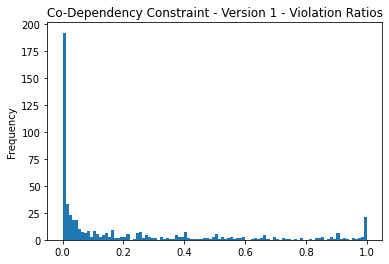

In [82]:
codepConstDF1['violation_ratio'].plot.hist(bins=100).set_title("Co-Dependency Constraint - Version 1 - Violation Ratios")

Text(0.5, 1.0, 'Co-Dependency Constraint - Version 1 - Violation Ratios <= 0.5')

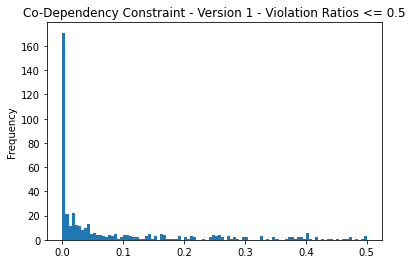

In [83]:
codepConstDF1[codepConstDF1['violation_ratio'] <= 0.5].violation_ratio.plot.hist(bins=100).set_title("Co-Dependency Constraint - Version 1 - Violation Ratios <= 0.5")

In [84]:
print(f"No. of properties whose violation ratio is greater than mean: {sum(codepConstDF1['violation_ratio'] >= 3.539484)}/{len(codepConstDF1)}")

No. of properties whose violation ratio is greater than mean: 0/534


In [85]:
codepConstDF1.to_csv('../../allConstraintsAnalysis_WRemoved_Final/codepConstDFAnalysis.csv')

#### Version 2 - Mand Normal

In [86]:
import pandas as pd
codepConstDF2 = pd.DataFrame(codepConstViolations['Mand_Normal']).T

In [87]:
codepConstDF2

correct incorrect                                              paths
P1018     186        16  [../../allConstraintsAnalysis_WRemoved_Final/c...
P1533    8328      9693  [../../allConstraintsAnalysis_WRemoved_Final/c...
P2009    1036        17  [../../allConstraintsAnalysis_WRemoved_Final/c...
P240    25801         9  [../../allConstraintsAnalysis_WRemoved_Final/c...
P3816      31        10  [../../allConstraintsAnalysis_WRemoved_Final/c...
...       ...       ...                                                ...
P3648       7         0  [../../allConstraintsAnalysis_WRemoved_Final/c...
P3701      72         1  [../../allConstraintsAnalysis_WRemoved_Final/c...
P3713     359         1  [../../allConstraintsAnalysis_WRemoved_Final/c...
P3744     377         1  [../../allConstraintsAnalysis_WRemoved_Final/c...
P3815     600         1  [../../allConstraintsAnalysis_WRemoved_Final/c...

[475 rows x 3 columns]

In [88]:
codepConstDF2['violation_ratio'] = codepConstDF2.apply(lambda p: p.incorrect / (p.correct + p.incorrect), axis=1)

In [89]:
codepConstDF2.sort_values(by=['violation_ratio'],ascending=False).head(15)

correct incorrect                                              paths  \
P2308       0        51  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2916       0         2  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P5448       0        23  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P5447       0        24  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2304       0         1  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2307       0         2  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2309       0        55  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P4680       0         2  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2310       0         4  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2842       0         1  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2311       0         4  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2312       0         5  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2313       0         4  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P8264       0         1  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P7569       0         9  [../../allConstraintsAnalysis_WRemoved_Final/c...   

       violation_ratio  
P2308              1.0  
P2916              1.0  
P5448              1.0  
P5447              1.0  
P2304              1.0  
P2307              1.0  
P2309              1.0  
P4680              1.0  
P2310              1.0  
P2842              1.0  
P2311              1.0  
P2312              1.0  
P2313              1.0  
P8264              1.0  
P7569              1.0

In [90]:
codepConstDF2.sort_values(by=['incorrect'],ascending=False).head(15)

correct incorrect                                              paths  \
P2214    2989348    721476  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P433    31113458    436995  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P275        7295    163856  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2860  174842113    152425  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P1435    2121637     92401  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P708       45718     57276  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P197      122018     52917  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P1598      40600     49329  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P1111          1     46803  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P856     1451949     44006  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2248       4025     41608  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2325       4079     40619  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2243       4035     36870  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2244       4036     36801  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P413      389145     35536  [../../allConstraintsAnalysis_WRemoved_Final/c...   

       violation_ratio  
P2214         0.194425  
P433          0.013851  
P275          0.957377  
P2860         0.000871  
P1435         0.041734  
P708          0.556110  
P197          0.302495  
P1598         0.548533  
P1111         0.999979  
P856          0.029417  
P2248         0.911796  
P2325         0.908743  
P2243         0.901357  
P2244         0.901168  
P413          0.083677

In [91]:
codepConstDF2['violation_ratio'].describe()

count    475.000000
mean       0.177493
std        0.289214
min        0.000000
25%        0.000966
50%        0.023847
75%        0.214528
max        1.000000
Name: violation_ratio, dtype: float64

Text(0.5, 1.0, 'Co-Dependency Constraint - Version 2 - Violation Ratios')

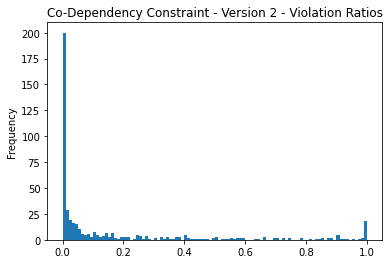

In [92]:
codepConstDF2['violation_ratio'].plot.hist(bins=100).set_title("Co-Dependency Constraint - Version 2 - Violation Ratios")

Text(0.5, 1.0, 'Co-Dependency Constraint - Version 2 - Violation Ratios <= 0.5')

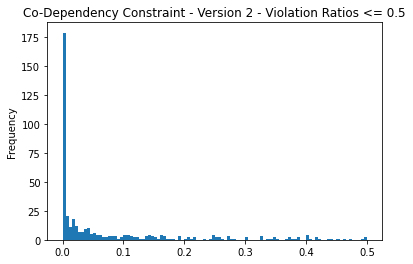

In [93]:
codepConstDF2[codepConstDF2['violation_ratio'] <= 0.5].violation_ratio.plot.hist(bins=100).set_title("Co-Dependency Constraint - Version 2 - Violation Ratios <= 0.5")

In [94]:
print(f"No. of properties whose violation ratio is greater than mean: {sum(codepConstDF2['violation_ratio'] >= 2.290915)}/{len(codepConstDF2)}")

No. of properties whose violation ratio is greater than mean: 0/475


#### Version 3 - Mand

In [95]:
import pandas as pd
codepConstDF3 = pd.DataFrame(codepConstViolations['Mand']).T

In [96]:
codepConstDF3

correct incorrect                                              paths
P564     18887         5  [../../allConstraintsAnalysis_WRemoved_Final/c...
P1081    12693         0  [../../allConstraintsAnalysis_WRemoved_Final/c...
P5982     1328         0  [../../allConstraintsAnalysis_WRemoved_Final/c...
P1087  3774635      1210  [../../allConstraintsAnalysis_WRemoved_Final/c...
P613     70608         5  [../../allConstraintsAnalysis_WRemoved_Final/c...
...        ...       ...                                                ...
P5105     2060         0  [../../allConstraintsAnalysis_WRemoved_Final/c...
P517       248         0  [../../allConstraintsAnalysis_WRemoved_Final/c...
P521      1757         0  [../../allConstraintsAnalysis_WRemoved_Final/c...
P555     17395         2  [../../allConstraintsAnalysis_WRemoved_Final/c...
P5623     1474         0  [../../allConstraintsAnalysis_WRemoved_Final/c...

[79 rows x 3 columns]

In [97]:
codepConstDF3['violation_ratio'] = codepConstDF3.apply(lambda p: p.incorrect / p.correct if p.correct != 0 else p.incorrect/100, axis=1)

In [98]:
codepConstDF3.sort_values(by=['violation_ratio'],ascending=False).head(15)

correct incorrect                                              paths  \
P5051       2        79  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P4341       8         1  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2095      38         3  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P990     1089        44  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P3931    2316        68  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P246      174         5  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P1713    2935        79  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P141   131232      3270  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P1731     382         8  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2009    1036        17  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P8264       0         1  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2842       0         1  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P1560    3459        33  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P1635     922         8  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P944      851         7  [../../allConstraintsAnalysis_WRemoved_Final/c...   

       violation_ratio  
P5051        39.500000  
P4341         0.125000  
P2095         0.078947  
P990          0.040404  
P3931         0.029361  
P246          0.028736  
P1713         0.026917  
P141          0.024918  
P1731         0.020942  
P2009         0.016409  
P8264         0.010000  
P2842         0.010000  
P1560         0.009540  
P1635         0.008677  
P944          0.008226

In [102]:
codepConstDF3.sort_values(by=['incorrect'],ascending=False).head(15)

correct incorrect                                              paths  \
P141    131232      3270  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P1087  3774635      1210  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P7959   657006       322  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P5051        2        79  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P1713     2935        79  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P3931     2316        68  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P451     12167        50  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P915     28966        47  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P197    174888        44  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P990      1089        44  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P1560     3459        33  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2962    29220        25  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2009     1036        17  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2364     9705        17  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2365     1851        10  [../../allConstraintsAnalysis_WRemoved_Final/c...   

       violation_ratio  
P141          0.024918  
P1087         0.000321  
P7959         0.000490  
P5051        39.500000  
P1713         0.026917  
P3931         0.029361  
P451          0.004109  
P915          0.001623  
P197          0.000252  
P990          0.040404  
P1560         0.009540  
P2962         0.000856  
P2009         0.016409  
P2364         0.001752  
P2365         0.005402

In [103]:
codepConstDF3['violation_ratio'].describe()

count    79.000000
mean      0.506010
std       4.443448
min       0.000000
25%       0.000000
50%       0.000260
75%       0.002110
max      39.500000
Name: violation_ratio, dtype: float64

Text(0.5, 1.0, 'Co-Dependency Constraint - Version 3 - Violation Ratios')

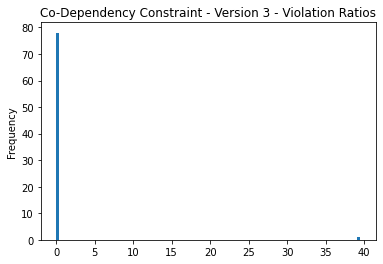

In [104]:
codepConstDF3['violation_ratio'].plot.hist(bins=100).set_title("Co-Dependency Constraint - Version 3 - Violation Ratios")

Text(0.5, 1.0, 'Co-Dependency Constraint - Version 3 - Violation Ratios <= 0.0005')

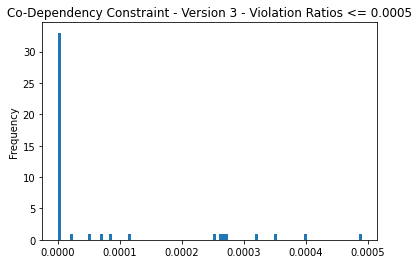

In [105]:
codepConstDF3[codepConstDF3['violation_ratio'] <= 0.0005].violation_ratio.plot.hist(bins=100).set_title("Co-Dependency Constraint - Version 3 - Violation Ratios <= 0.0005")

In [106]:
print(f"No. of properties whose violation ratio is greater than mean: {sum(codepConstDF3['violation_ratio'] >= 0.922928)}/{len(codepConstDF3)}")

No. of properties whose violation ratio is greater than mean: 1/79


#### Version 4 - Normal

In [107]:
import pandas as pd
codepConstDF4 = pd.DataFrame(codepConstViolations['Normal']).T

In [108]:
codepConstDF4

correct incorrect                                              paths
P1018     186        16  [../../allConstraintsAnalysis_WRemoved_Final/c...
P1539  243577       551  [../../allConstraintsAnalysis_WRemoved_Final/c...
P209      163         1  [../../allConstraintsAnalysis_WRemoved_Final/c...
P574     5524        92  [../../allConstraintsAnalysis_WRemoved_Final/c...
P746      941       325  [../../allConstraintsAnalysis_WRemoved_Final/c...
...       ...       ...                                                ...
P410   138058       813  [../../allConstraintsAnalysis_WRemoved_Final/c...
P411     7629      5541  [../../allConstraintsAnalysis_WRemoved_Final/c...
P413   389145     35536  [../../allConstraintsAnalysis_WRemoved_Final/c...
P418       96        11  [../../allConstraintsAnalysis_WRemoved_Final/c...
P4213   42655        14  [../../allConstraintsAnalysis_WRemoved_Final/c...

[424 rows x 3 columns]

In [109]:
codepConstDF4['violation_ratio'] = codepConstDF4.apply(lambda p: p.incorrect / p.correct if p.correct != 0 else p.incorrect/100, axis=1)

In [110]:
codepConstDF4.sort_values(by=['violation_ratio'],ascending=False).head(15)

correct incorrect                                              paths  \
P1111       1     46803  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P1995      89     11360  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P4501     425     22684  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P768      297     15346  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P275     7295    163856  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2306       1        15  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P3912     312      3775  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2248    4025     41608  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2303       4        40  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2325    4079     40619  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2720      15       140  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2243    4035     36870  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2244    4036     36801  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P3448     579      4620  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P1183     683      5394  [../../allConstraintsAnalysis_WRemoved_Final/c...   

       violation_ratio  
P1111     46803.000000  
P1995       127.640449  
P4501        53.374118  
P768         51.670034  
P275         22.461412  
P2306        15.000000  
P3912        12.099359  
P2248        10.337391  
P2303        10.000000  
P2325         9.958078  
P2720         9.333333  
P2243         9.137546  
P2244         9.118186  
P3448         7.979275  
P1183         7.897511

In [112]:
codepConstDF4.sort_values(by=['incorrect'],ascending=False).head(15)

correct incorrect                                              paths  \
P2214    2989348    721476  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P433    31113458    436995  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P275        7295    163856  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2860  174842113    152425  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P1435    2121637     92401  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P708       45718     57276  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P197      122018     52917  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P1598      40600     49329  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P1111          1     46803  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P856     1451949     44006  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2248       4025     41608  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2325       4079     40619  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2243       4035     36870  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P2244       4036     36801  [../../allConstraintsAnalysis_WRemoved_Final/c...   
P413      389145     35536  [../../allConstraintsAnalysis_WRemoved_Final/c...   

       violation_ratio  
P2214         0.241349  
P433          0.014045  
P275         22.461412  
P2860         0.000872  
P1435         0.043552  
P708          1.252811  
P197          0.433682  
P1598         1.215000  
P1111     46803.000000  
P856          0.030308  
P2248        10.337391  
P2325         9.958078  
P2243         9.137546  
P2244         9.118186  
P413          0.091318

In [113]:
codepConstDF4['violation_ratio'].describe()

count      424.000000
mean       111.550177
std       2272.909916
min          0.000000
25%          0.001966
50%          0.036278
75%          0.260204
max      46803.000000
Name: violation_ratio, dtype: float64

Text(0.5, 1.0, 'Co-Dependency Constraint - Version 4 - Violation Ratios')

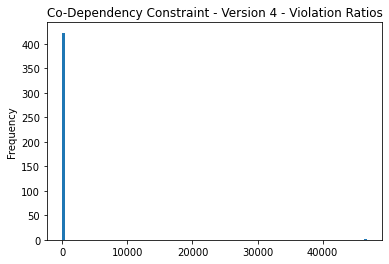

In [114]:
codepConstDF4['violation_ratio'].plot.hist(bins=100).set_title("Co-Dependency Constraint - Version 4 - Violation Ratios")

Text(0.5, 1.0, 'Co-Dependency Constraint - Version 4 - Violation Ratios <= 0.5')

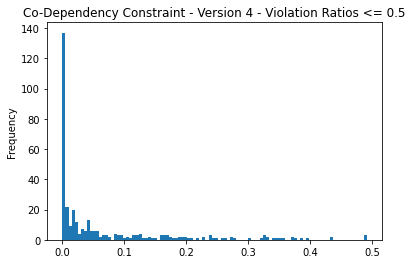

In [115]:
codepConstDF4[codepConstDF4['violation_ratio'] <= 0.5].violation_ratio.plot.hist(bins=100).set_title("Co-Dependency Constraint - Version 4 - Violation Ratios <= 0.5")

In [116]:
print(f"No. of properties whose violation ratio is greater than mean: {sum(codepConstDF4['violation_ratio'] >= 2.414703)}/{len(codepConstDF4)}")

No. of properties whose violation ratio is greater than mean: 29/424


### Find out time required

In [ ]:
import pandas as pd
import os
from tqdm.notebook import tqdm

codepConstViolations = {}

codepConstViolations = {}
codepConstPropList = set()

def extractTimes(filename):
    times = []
    with open(filename) as f:
        for line in f:
            if "real" in line:
                line = line.strip()
                time1 = line.split("\t")[1]
                mins, sec = time1.split("m")
                mins = int(mins)
                sec = float(sec[:-1])
                times.append(60 * mins + sec)
    return times

# codepConstViolationsSummary = {}
times = []
timesVersion = {"MSN": [], "MN": [], "M": [], "N": [], "S": []}
filePath = '/data/wd-correctness/propertiesSplit_WRemoved_Final/checkViolations/exec_logs/'
for filename in tqdm(os.listdir(filePath)):
    if filename.startswith("timeLog_codepConst_"):
        ver = filename.split('_')[2]
        tempTimes = extractTimes(filePath + filename)
        times += tempTimes
        timesVersion[ver] += tempTimes
print(pd.Series(times).describe())

In [ ]:
print(pd.Series(timesVersion['MSN']).describe())

In [ ]:
print(pd.Series(timesVersion['MN']).describe())

In [ ]:
print(pd.Series(timesVersion['M']).describe())

In [ ]:
print(pd.Series(timesVersion['N']).describe())

## Symmetric Constraint (Q21510862)

This constraint says, if node1 has a property with this constraint, then both `(node1)-[prop]->(node2)` and `(node2)-[prop]->(node1)` must be present with few exceptions

### Constraints File

In [25]:
!kgtk --debug query -i ../../gdrive-kgtk-dump-2020-12-07/claims.properties.tsv.gz \
    ../../gdrive-kgtk-dump-2020-12-07/qualifiers.properties.tsv.gz \
    --match "p: (nodeProp1)-[nodePropEdge:P2302]->(:Q21510862)" \
    -o ../../constraintsOP/symmetricConstraint/claims.constraints_list.tsv \
    --graph-cache ~/sqlite3_caches/temp1345.valuetype.sqlite3.db

[2021-04-15 07:17:19 query]: SQL Translation:
---------------------------------------------
  SELECT *
     FROM graph_1 AS graph_1_c1
     WHERE graph_1_c1."label"=?
     AND graph_1_c1."node2"=?
  PARAS: ['P2302', 'Q21510862']
---------------------------------------------


In [26]:
import pandas as pd
qualiDF = pd.read_csv("../../gdrive-kgtk-dump-2020-12-07/qualifiers.properties.tsv.gz",sep='\t')
constDF = pd.read_csv("../../constraintsOP/symmetricConstraint/claims.constraints_list.tsv",sep='\t')

In [27]:
constDF2 = constDF.set_index('id').join(qualiDF.set_index('node1'),rsuffix='_qualifier').drop(columns=['id', 'node2;wikidatatype_qualifier', 'rank', 'node2', 'label', 'node2;wikidatatype']).rename(columns={'label_qualifier':'label', 'node2_qualifier': 'node2'})
constDF2 = constDF2.reset_index()
constDF2 = constDF2.rename(columns={'index':'id'})
constDF2['label'] = constDF2.label.fillna("P2316")
constDF2['node2'] = constDF2.node2.fillna("Normal")

In [28]:
constDF2.to_csv("../../constraintsOP/symmetricConstraint/claims.constraints_all.tsv",sep="\t",index=False)

In [29]:
import pandas as pd
import math
dfItemRequires = pd.read_csv('../../constraintsOP/symmetricConstraint/claims.constraints_all.tsv',sep='\t')

In [30]:
dfItemRequires = dfItemRequires.groupby(['id','node1','label']).node2.apply(lambda p: p.tolist()).reset_index()

In [31]:
dfItemRequires['label'].unique()

array(['P2316', 'P2303'], dtype=object)

In [33]:
#Reference: https://stackoverflow.com/a/17298454
# dfItemRequires.pivot_table('node2', ['node1', 'id'], 'label')
dfItemRequires = dfItemRequires.pivot(index=['node1','id'], columns='label', values='node2')

In [34]:
dfItemRequires.head()

label                                  P2303        P2316
node1 id                                                 
P1322 P1322-P2302-Q21510862-85dea891-0   NaN     [Normal]
P1327 P1327-P2302-Q21510862-a3c3a094-0   NaN     [Normal]
P1382 P1382-P2302-Q21510862-f6bcfecf-0   NaN     [Normal]
P1560 P1560-P2302-Q21510862-fabecaeb-0   NaN  [Q21502408]
P1639 P1639-P2302-Q21510862-384edcd4-0   NaN  [Q21502408]

In [35]:
dfItemRequires = dfItemRequires.droplevel(1)

In [36]:
dfItemRequires.head()

label P2303        P2316
node1                   
P1322   NaN     [Normal]
P1327   NaN     [Normal]
P1382   NaN     [Normal]
P1560   NaN  [Q21502408]
P1639   NaN  [Q21502408]

### Query Generator

In [37]:
from tqdm.notebook import tqdm
import os.path
import os

cnt = 0
fCnt = 0

folderName = 'symmetricConstraint'
shellFileSuffix = 'symmConst_Validator_'
graph_cache_prefix = 'symm_new_11_1_'

for row in tqdm(dfItemRequires.iterrows()):
#     try:
        prop = row[0]
        constraint = row[1]
        mandatory = []
        suggestion = []
        normal = []
        prop = str(prop)
        
        if type(constraint['P2316']) == list:
            if constraint['P2316'][0] == 'Q21502408':
                sfname = 'mandatory'
            elif constraint['P2316'][0] == 'Q62026391':
                sfname = 'suggestion'
            elif constraint['P2316'][0] == 'Normal':
                sfname = 'normal'
        else:
            sfname = 'normal'
        
        if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv")):
            continue
                
        command = "{ time ( kgtk --debug query -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
                    ../../propertiesSplit_WRemoved_Final/claims."+ prop +".copy2.tsv \
                    --match 'tsv: (node1)-[nodeProp]->(node2), copy2: (node2)-[]->(node1)' "
        
        os.system("cp ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv ../../propertiesSplit_WRemoved_Final/claims."+ prop +".copy2.tsv")
        
        if cnt % 60 == 0:
            fCnt += 1
            fOP = open("../../propertiesSplit_WRemoved_Final/checkViolations/" + shellFileSuffix + str(fCnt) + ".sh","w")
        command
        if type(constraint['P2303']) != list: # Exceptions not present
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + sfname + "/claims."+ prop +".correct.tsv \
            --graph-cache ~/sqlite3_caches/"+graph_cache_prefix+"_" + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + sfname + "/claims."+ prop +".correct.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + sfname + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect.tsv ) } 2>> ../../propertiesSplit_WRemoved_Final/checkViolations/exec_logs/" + shellFileSuffix + str(fCnt) + ".txt;\n"
#             print(command)
            fOP.write(command)
        else:
            excptns = constraint['P2303']
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + sfname + "/claims."+ prop +".correct_wo_exceptions.tsv \
            --graph-cache ~/sqlite3_caches/"+graph_cache_prefix+"_" + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + sfname + "/claims."+ prop +".correct_wo_exceptions.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + sfname + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect_wo_exceptions.tsv; "
#             print(command)
            fOP.write(command)
            
            command = " kgtk --debug query -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + sfname + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
                    --match '(node1)-[]->()' --where 'node1 in " + str(list(excptns)).replace("'",'"') + "' \
                    -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + sfname + "/claims." + prop + ".correct_exceptions.tsv \
                    --graph-cache ~/sqlite3_caches/"+graph_cache_prefix+"_" + str(fCnt) + ".sqlite3.db; "
#             print(command)
            fOP.write(command)
            
            command = "  kgtk --debug ifnotexists -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + sfname + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + sfname + "/claims." + prop + ".correct_exceptions.tsv \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + sfname + "/claims."+ prop +".incorrect.tsv; "
#             print(command)
            fOP.write(command)
            
            command = " kgtk cat -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + sfname + "/claims."+ prop +".correct_wo_exceptions.tsv \
                    ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + sfname + "/claims."+ prop +".correct_exceptions.tsv \
                    -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + sfname + "/claims."+ prop +".correct.tsv ) } 2>> ../../propertiesSplit_WRemoved_Final/checkViolations/exec_logs/" + shellFileSuffix + str(fCnt) + ".txt;\n"
#             print(command)
            fOP.write(command)
        
        
        cnt += 1
#     except:
#         print("Something failed for prop:",prop)

0it [00:00, ?it/s]

In [38]:
cnt

39

In [59]:
# import os
# for i in range(1,3):
#     os.system("screen -dm sh ../../propertiesSplit_WRemoved_Final/checkViolations/symmConst_Validator_"+str(i)+".sh")

### Analyze Violations

In [117]:
import pandas as pd
import os
from tqdm.notebook import tqdm

symmConstViolations = {}

def countLines(fname):
    cnt = -1
    with open(fname, 'r') as f:
        for line in f:
            cnt += 1
    return cnt 

symmConstViolations = {}
symmConstPropList = set()

# codepConstViolationsSummary = {}


filePath = "../../allConstraintsAnalysis_WRemoved_Final/symmetricConstraint/"
for folder in tqdm(iter(['mandatory','normal','suggestion'])):
    for filename in tqdm(os.listdir(filePath + folder)):
        prop = filename.split(".")[1]
        correctness = filename.split(".")[2]
        if correctness not in ['correct','incorrect']:
            continue
        symmConstPropList.add(prop)
        count1 = countLines(filePath+folder+'/'+filename)
        if folder not in symmConstViolations:
            symmConstViolations[folder] = {}
        if prop not in symmConstViolations[folder]:
            symmConstViolations[folder][prop] = {'correct': 0, 'incorrect': 0, 'paths': []}
        symmConstViolations[folder][prop][correctness] = count1
        symmConstViolations[folder][prop]['paths'].append(filePath+folder+'/'+filename)

0it [00:00, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [118]:
len(symmConstPropList)

39

In [119]:
symmConstViolationsSummary = {}
for folder in tqdm(iter(['mandatory','normal','suggestion'])):
    symmConstViolationsSummary[folder] = {'correct': 0, 'incorrect': 0}
    for prop in symmConstViolations[folder].keys():
        symmConstViolationsSummary[folder]['correct'] += symmConstViolations[folder][prop]['correct']
        symmConstViolationsSummary[folder]['incorrect'] += symmConstViolations[folder][prop]['incorrect']
    symmConstViolationsSummary[folder]['total'] = symmConstViolationsSummary[folder]['correct'] + symmConstViolationsSummary[folder]['incorrect']
    symmConstViolationsSummary[folder]['percIncorrect'] = symmConstViolationsSummary[folder]['incorrect'] / symmConstViolationsSummary[folder]['total'] * 100
    symmConstViolationsSummary[folder]['propCount'] = len(symmConstViolations[folder].keys())

0it [00:00, ?it/s]

In [120]:
symmConstViolationsSummary

{'mandatory': {'correct': 7720,
  'incorrect': 61,
  'total': 7781,
  'percIncorrect': 0.7839609304716617,
  'propCount': 5},
 'normal': {'correct': 9553481,
  'incorrect': 7602206,
  'total': 17155687,
  'percIncorrect': 44.313037420186085,
  'propCount': 31},
 'suggestion': {'correct': 806179,
  'incorrect': 59278,
  'total': 865457,
  'percIncorrect': 6.849329313876947,
  'propCount': 3}}

In [121]:
noOfStmts = 0
for fold in symmConstViolationsSummary.keys():
    noOfStmts += symmConstViolationsSummary[fold]['total']
noOfStmts

18028925

In [122]:
symmConstDF1 = pd.DataFrame(symmConstViolations['mandatory']).T
symmConstDF1['violation_ratio'] = symmConstDF1.apply(lambda p: p.incorrect / (p.incorrect + p.correct), axis=1)
symmConstDF1.sort_values(by=['violation_ratio'],ascending=False).head(15)

correct incorrect                                              paths  \
P2152      80         1  [../../allConstraintsAnalysis_WRemoved_Final/s...   
P1639    2094        26  [../../allConstraintsAnalysis_WRemoved_Final/s...   
P1560    3459        33  [../../allConstraintsAnalysis_WRemoved_Final/s...   
P3364    1806         1  [../../allConstraintsAnalysis_WRemoved_Final/s...   
P6185     281         0  [../../allConstraintsAnalysis_WRemoved_Final/s...   

       violation_ratio  
P2152         0.012346  
P1639         0.012264  
P1560         0.009450  
P3364         0.000553  
P6185         0.000000

In [123]:
symmConstDF2 = pd.DataFrame(symmConstViolations['suggestion']).T
symmConstDF2['violation_ratio'] = symmConstDF2.apply(lambda p: p.incorrect / (p.incorrect + p.correct), axis=1)
symmConstDF2.sort_values(by=['violation_ratio'],ascending=False).head(15)

correct incorrect                                              paths  \
P2789  104551     24812  [../../allConstraintsAnalysis_WRemoved_Final/s...   
P1889  530234     30928  [../../allConstraintsAnalysis_WRemoved_Final/s...   
P197   171394      3538  [../../allConstraintsAnalysis_WRemoved_Final/s...   

       violation_ratio  
P2789         0.191801  
P1889         0.055114  
P197          0.020225

In [124]:
symmConstDF3 = pd.DataFrame(symmConstViolations['normal']).T
symmConstDF3['violation_ratio'] = symmConstDF3.apply(lambda p: p.incorrect / (p.incorrect + p.correct), axis=1)
symmConstDF3.sort_values(by=['violation_ratio'],ascending=False).head(15)

correct incorrect                                              paths  \
P5974        0         1  [../../allConstraintsAnalysis_WRemoved_Final/s...   
P5188        0         5  [../../allConstraintsAnalysis_WRemoved_Final/s...   
P1706       12        97  [../../allConstraintsAnalysis_WRemoved_Final/s...   
P521       421      1336  [../../allConstraintsAnalysis_WRemoved_Final/s...   
P2652      498       911  [../../allConstraintsAnalysis_WRemoved_Final/s...   
P684   7523178   7524749  [../../allConstraintsAnalysis_WRemoved_Final/s...   
P8702        6         2  [../../allConstraintsAnalysis_WRemoved_Final/s...   
P1382    10837      2911  [../../allConstraintsAnalysis_WRemoved_Final/s...   
P3032     1730       358  [../../allConstraintsAnalysis_WRemoved_Final/s...   
P2293    12492      2321  [../../allConstraintsAnalysis_WRemoved_Final/s...   
P451     10935      1285  [../../allConstraintsAnalysis_WRemoved_Final/s...   
P1327     7908       860  [../../allConstraintsAnalysis_WRemoved_Final/s...   
P4545       46         4  [../../allConstraintsAnalysis_WRemoved_Final/s...   
P4915      328        28  [../../allConstraintsAnalysis_WRemoved_Final/s...   
P530      6730       484  [../../allConstraintsAnalysis_WRemoved_Final/s...   

       violation_ratio  
P5974         1.000000  
P5188         1.000000  
P1706         0.889908  
P521          0.760387  
P2652         0.646558  
P684          0.500052  
P8702         0.250000  
P1382         0.211740  
P3032         0.171456  
P2293         0.156687  
P451          0.105155  
P1327         0.098084  
P4545         0.080000  
P4915         0.078652  
P530          0.067092

Text(0.5, 1.0, 'Symmetric Normal Constraint - Violation Ratios')

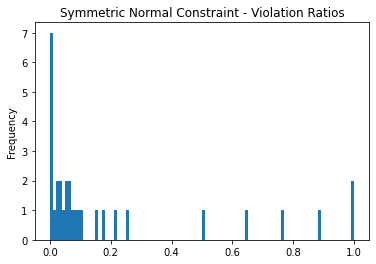

In [126]:
symmConstDF3.sort_values(by=['violation_ratio'],ascending=False)['violation_ratio'].plot.hist(bins=100).set_title("Symmetric Normal Constraint - Violation Ratios")

In [127]:
pd.concat([symmConstDF1, symmConstDF2, symmConstDF3]).to_csv('../../allConstraintsAnalysis_WRemoved_Final/symmConstDFAnalysis.csv')

### Find out time required

In [ ]:
import pandas as pd
import os
from tqdm.notebook import tqdm

codepConstViolations = {}

codepConstViolations = {}
codepConstPropList = set()

def extractTimes(filename):
    times = []
    with open(filename) as f:
        for line in f:
            if "real" in line:
                line = line.strip()
                time1 = line.split("\t")[1]
                mins, sec = time1.split("m")
                mins = int(mins)
                sec = float(sec[:-1])
                times.append(60 * mins + sec)
    return times

# codepConstViolationsSummary = {}
times = []
filePath = '/data/wd-correctness/propertiesSplit_WRemoved_Final/checkViolations/exec_logs/'
for filename in tqdm(os.listdir(filePath)):
    if filename.startswith("symmConst_Validator_"):
        tempTimes = extractTimes(filePath + filename)
        times += tempTimes

In [ ]:
print(pd.Series(times).describe())

In [ ]:
import seaborn as sns
sns.lineplot(data=pd.Series(times)).set_title("Distribution of times (in s) taken for symmetric constraint checks")

## Inverse Constraint (Q21510855)

This constraint says, if node1 has a property with this constraint, then node2 must have the specified property and the value must be node1.

### Constraints File

In [39]:
!kgtk --debug query -i ../../gdrive-kgtk-dump-2020-12-07/claims.properties.tsv.gz \
    ../../gdrive-kgtk-dump-2020-12-07/qualifiers.properties.tsv.gz \
    --match "p: (nodeProp1)-[nodePropEdge:P2302]->(:Q21510855)" \
    -o ../../constraintsOP/inverseConstraint/claims.constraints_list.tsv \
    --graph-cache ~/sqlite3_caches/temp1345.valuetype.sqlite3.db

[2021-04-15 07:17:37 query]: SQL Translation:
---------------------------------------------
  SELECT *
     FROM graph_1 AS graph_1_c1
     WHERE graph_1_c1."label"=?
     AND graph_1_c1."node2"=?
  PARAS: ['P2302', 'Q21510855']
---------------------------------------------


In [40]:
!head ../../constraintsOP/inverseConstraint/claims.constraints_list.tsv

id	node1	label	node2	rank	node2;wikidatatype
P1026-P2302-Q21510855-adc83b86-0	P1026	P2302	Q21510855	normal	wikibase-item
P1029-P2302-Q21510855-6b55e057-0	P1029	P2302	Q21510855	normal	wikibase-item
P115-P2302-Q21510855-f7aa0b78-0	P115	P2302	Q21510855	normal	wikibase-item
P1151-P2302-Q21510855-0d9aa9c6-0	P1151	P2302	Q21510855	normal	wikibase-item
P1204-P2302-Q21510855-e3d53bb6-0	P1204	P2302	Q21510855	normal	wikibase-item
P1283-P2302-Q21510855-0e7699bb-0	P1283	P2302	Q21510855	normal	wikibase-item
P1308-P2302-Q21510855-2aba96b7-0	P1308	P2302	Q21510855	normal	wikibase-item
P1365-P2302-Q21510855-c809b758-0	P1365	P2302	Q21510855	normal	wikibase-item
P1366-P2302-Q21510855-eee12ef8-0	P1366	P2302	Q21510855	normal	wikibase-item


In [41]:
import pandas as pd
qualiDF = pd.read_csv("../../gdrive-kgtk-dump-2020-12-07/qualifiers.properties.tsv.gz",sep='\t')
constDF = pd.read_csv("../../constraintsOP/inverseConstraint/claims.constraints_list.tsv",sep='\t')

In [42]:
constDF2 = constDF.set_index('id').join(qualiDF.set_index('node1'),rsuffix='_qualifier').drop(columns=['id', 'node2;wikidatatype_qualifier', 'rank', 'node2', 'label', 'node2;wikidatatype']).rename(columns={'label_qualifier':'label', 'node2_qualifier': 'node2'})
constDF2 = constDF2.reset_index()
constDF2 = constDF2.rename(columns={'index':'id'})
constDF2['label'] = constDF2.label.fillna("P2316")
constDF2['node2'] = constDF2.node2.fillna("Normal")

In [43]:
constDF2.to_csv("../../constraintsOP/inverseConstraint/claims.constraints_all.tsv",sep="\t",index=False)

In [44]:
import pandas as pd
import math
dfItemRequires = pd.read_csv('../../constraintsOP/inverseConstraint/claims.constraints_all.tsv',sep='\t')

In [45]:
dfItemRequires = dfItemRequires.groupby(['id','node1','label']).node2.apply(lambda p: p.tolist()).reset_index()

In [46]:
dfItemRequires['label'].unique()

array(['P2306', 'P2316', 'P4155', 'P2303'], dtype=object)

In [48]:
#Reference: https://stackoverflow.com/a/17298454
# dfItemRequires.pivot_table('node2', ['node1', 'id'], 'label')
dfItemRequires = dfItemRequires.pivot(index=['node1','id'], columns='label', values='node2')

In [49]:
dfItemRequires.head()

label                                  P2303    P2306        P2316 P4155
node1 id                                                                
P1026 P1026-P2302-Q21510855-adc83b86-0   NaN    [P50]          NaN   NaN
P1029 P1029-P2302-Q21510855-6b55e057-0   NaN  [P5096]          NaN   NaN
P115  P115-P2302-Q21510855-f7aa0b78-0    NaN   [P466]          NaN   NaN
P1151 P1151-P2302-Q21510855-0d9aa9c6-0   NaN  [P1204]  [Q21502408]   NaN
P1204 P1204-P2302-Q21510855-e3d53bb6-0   NaN  [P1151]          NaN   NaN

In [50]:
dfItemRequires = dfItemRequires.droplevel(1)

In [51]:
dfItemRequires.head()

label P2303    P2306        P2316 P4155
node1                                  
P1026   NaN    [P50]          NaN   NaN
P1029   NaN  [P5096]          NaN   NaN
P115    NaN   [P466]          NaN   NaN
P1151   NaN  [P1204]  [Q21502408]   NaN
P1204   NaN  [P1151]          NaN   NaN

### Query Generator

In [52]:
from tqdm.notebook import tqdm
import os.path
import os

cnt = 0
fCnt = 0
fOP = None

folderName = 'inverseConstraint'
shellFileSuffix = 'invConst_Validator_'
graph_cache_file_prefix = "inv_new_11_1_"

for prop, constraint in tqdm(dfItemRequires.iterrows()):
#     try:
        
        if type(constraint['P2316']) == list:
            if constraint['P2316'][0] == 'Q21502408':
                subFolderName = "mandatory"
            elif constraint['P2316'][0] == 'Q62026391':
                subFolderName = "suggestion"
        else:
            subFolderName = "normal"
        
        if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv")):
            continue
            
        prop2 = constraint['P2306']

        if type(prop2) != list:
            continue
        prop2 = prop2[0]

        if not(os.path.isfile("../../propertiesSplit_WRemoved_Final/claims."+ prop2 +".tsv")):
            print(f"File: ../../propertiesSplit_WRemoved_Final/claims.{prop2}.tsv does not exist")
            continue
        
        if cnt % 60 == 0:
            if fOP:
                fOP.close()
            fCnt += 1
            fOP = open("../../propertiesSplit_WRemoved_Final/checkViolations/" + shellFileSuffix + str(fCnt) + ".sh","w")
        
            
        command = "{ time ( kgtk --debug query -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
                        ../../propertiesSplit_WRemoved_Final/claims."+ prop2 +".tsv \
                        --match '"+ \
                        f"{prop}: (node1)-[nodeProp]->(node2), {prop2}: (node2)-[]->(node1)' "

        if type(constraint['P2303']) != list: # Exceptions not present
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv \
            --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect.tsv ) } 2>> ../../propertiesSplit_WRemoved_Final/checkViolations/exec_logs/" + shellFileSuffix + str(fCnt) + ".txt;\n"
#             print(command)
            fOP.write(command)
        else:
            excptns = set(constraint['P2303'])
            commandRest = " --return 'distinct nodeProp.id, node1 as `node1`, nodeProp.label as `label`, node2 as `node2`'  \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
            --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; \
             kgtk --debug ifnotexists -i ../../propertiesSplit_WRemoved_Final/claims."+ prop +".tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv "
            
            commandOPFile = "-o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +"."
            
            command += commandRest + commandOPFile + "incorrect_wo_exceptions.tsv; "
#             print(command)
            fOP.write(command)
            
            command = "  kgtk --debug query -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
                    --match '(node1)-[]->()' --where 'node1 in " + str(list(excptns)).replace("'",'"') + "' \
                    -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv \
                    --graph-cache ~/sqlite3_caches/" + str(graph_cache_file_prefix) + str(fCnt) + ".sqlite3.db; "
#             print(command)        
            fOP.write(command)
            
            command = "  kgtk --debug ifnotexists -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_wo_exceptions.tsv \
            --filter-on ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims." + prop + ".incorrect_w_exceptions.tsv \
            -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect.tsv; "
#             print(command)
            fOP.write(command)
            
            command = "  kgtk cat -i ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct_wo_exceptions.tsv \
                    ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".incorrect_w_exceptions.tsv \
                    -o ../../allConstraintsAnalysis_WRemoved_Final/" + folderName + "/" + subFolderName + "/claims."+ prop +".correct.tsv ) } 2>> ../../propertiesSplit_WRemoved_Final/checkViolations/exec_logs/" + shellFileSuffix + str(fCnt) + ".txt; \n"
#             print(command)
            fOP.write(command)
        
        
        cnt += 1
#     except:
#         print("Something failed for prop:",prop)
if fOP:
    fOP.close()

0it [00:00, ?it/s]

In [53]:
cnt

110

In [60]:
# import os
# for i in range(1,7):
#     os.system("screen -dm sh ../../propertiesSplit_WRemoved_Final/checkViolations/invConst_Validator_"+str(i)+".sh")

### Analyze Violations

In [129]:
import pandas as pd
import os
from tqdm.notebook import tqdm

invConstViolations = {}

def countLines(fname):
    cnt = -1
    with open(fname, 'r') as f:
        for line in f:
            cnt += 1
    return cnt

invConstViolations = {}
invConstPropList = set()

# codepConstViolationsSummary = {}


filePath = "../../allConstraintsAnalysis_WRemoved_Final/inverseConstraint/"
for folder in tqdm(iter(['mandatory','normal','suggestion'])):
    for filename in tqdm(os.listdir(filePath + folder)):
        prop = filename.split(".")[1]
        correctness = filename.split(".")[2]
        if correctness not in ['correct','incorrect']:
            continue
        invConstPropList.add(prop)
        count1 = countLines(filePath+folder+'/'+filename)
        if folder not in invConstViolations:
            invConstViolations[folder] = {}
        if prop not in invConstViolations[folder]:
            invConstViolations[folder][prop] = {'correct': 0, 'incorrect': 0, 'paths': []}
        invConstViolations[folder][prop][correctness] = count1
        invConstViolations[folder][prop]['paths'].append(filePath+folder+'/'+filename)

0it [00:00, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [130]:
len(invConstPropList)

110

In [131]:
invConstViolationsSummary = {}
for folder in tqdm(iter(['mandatory','normal','suggestion'])):
    invConstViolationsSummary[folder] = {'correct': 0, 'incorrect': 0}
    for prop in invConstViolations[folder].keys():
        invConstViolationsSummary[folder]['correct'] += invConstViolations[folder][prop]['correct']
        invConstViolationsSummary[folder]['incorrect'] += invConstViolations[folder][prop]['incorrect']
    invConstViolationsSummary[folder]['total'] = invConstViolationsSummary[folder]['correct'] + invConstViolationsSummary[folder]['incorrect']
    invConstViolationsSummary[folder]['percIncorrect'] = invConstViolationsSummary[folder]['incorrect'] / invConstViolationsSummary[folder]['total'] * 100
    invConstViolationsSummary[folder]['propCount'] = len(invConstViolations[folder].keys())

0it [00:00, ?it/s]

In [132]:
invConstViolationsSummary

{'mandatory': {'correct': 6872,
  'incorrect': 170,
  'total': 7042,
  'percIncorrect': 2.4140869071286564,
  'propCount': 6},
 'normal': {'correct': 7489249,
  'incorrect': 381880,
  'total': 7871129,
  'percIncorrect': 4.851654699090817,
  'propCount': 100},
 'suggestion': {'correct': 2150990,
  'incorrect': 107016,
  'total': 2258006,
  'percIncorrect': 4.739402818238747,
  'propCount': 4}}

In [133]:
noOfStmts = 0
for fold in invConstViolationsSummary.keys():
    noOfStmts += invConstViolationsSummary[fold]['total']
noOfStmts

10136177

In [134]:
invConstDF1 = pd.DataFrame(invConstViolations['mandatory']).T
invConstDF1['violation_ratio'] = invConstDF1.apply(lambda p: p.incorrect / (p.correct + p.incorrect), axis=1)
invConstDF1.sort_values(by=['violation_ratio'],ascending=False).head(15)

correct incorrect                                              paths  \
P2673     839        70  [../../allConstraintsAnalysis_WRemoved_Final/i...   
P4147     286         8  [../../allConstraintsAnalysis_WRemoved_Final/i...   
P450     1779        30  [../../allConstraintsAnalysis_WRemoved_Final/i...   
P1151    1803        30  [../../allConstraintsAnalysis_WRemoved_Final/i...   
P2033    1879        28  [../../allConstraintsAnalysis_WRemoved_Final/i...   
P4149     286         4  [../../allConstraintsAnalysis_WRemoved_Final/i...   

       violation_ratio  
P2673         0.077008  
P4147         0.027211  
P450          0.016584  
P1151         0.016367  
P2033         0.014683  
P4149         0.013793

In [135]:
invConstDF2 = pd.DataFrame(invConstViolations['suggestion']).T
invConstDF2['violation_ratio'] = invConstDF2.apply(lambda p: p.incorrect / (p.correct + p.incorrect), axis=1)
invConstDF2.sort_values(by=['violation_ratio'],ascending=False).head(15)

correct incorrect                                              paths  \
P1434     3677      5071  [../../allConstraintsAnalysis_WRemoved_Final/i...   
P155   1036647     56650  [../../allConstraintsAnalysis_WRemoved_Final/i...   
P156   1036636     44187  [../../allConstraintsAnalysis_WRemoved_Final/i...   
P629     74030      1108  [../../allConstraintsAnalysis_WRemoved_Final/i...   

       violation_ratio  
P1434         0.579675  
P155          0.051816  
P156          0.040883  
P629          0.014746

In [136]:
invConstDF3 = pd.DataFrame(invConstViolations['normal']).T
invConstDF3['violation_ratio'] = invConstDF3.apply(lambda p: p.incorrect / (p.correct + p.incorrect), axis=1)
invConstDF3.sort_values(by=['violation_ratio'],ascending=False).head(15)

correct incorrect                                              paths  \
P1605      13       191  [../../allConstraintsAnalysis_WRemoved_Final/i...   
P3448     605      4595  [../../allConstraintsAnalysis_WRemoved_Final/i...   
P926        1         6  [../../allConstraintsAnalysis_WRemoved_Final/i...   
P1029     490      2662  [../../allConstraintsAnalysis_WRemoved_Final/i...   
P925        1         5  [../../allConstraintsAnalysis_WRemoved_Final/i...   
P115     6948     25081  [../../allConstraintsAnalysis_WRemoved_Final/i...   
P5134      23        54  [../../allConstraintsAnalysis_WRemoved_Final/i...   
P3816      14        27  [../../allConstraintsAnalysis_WRemoved_Final/i...   
P1283    1405      2479  [../../allConstraintsAnalysis_WRemoved_Final/i...   
P8625       9        15  [../../allConstraintsAnalysis_WRemoved_Final/i...   
P425     2741      3337  [../../allConstraintsAnalysis_WRemoved_Final/i...   
P5132      81        90  [../../allConstraintsAnalysis_WRemoved_Final/i...   
P2512     221       172  [../../allConstraintsAnalysis_WRemoved_Final/i...   
P1677       6         4  [../../allConstraintsAnalysis_WRemoved_Final/i...   
P2578    1111       723  [../../allConstraintsAnalysis_WRemoved_Final/i...   

       violation_ratio  
P1605         0.936275  
P3448         0.883654  
P926          0.857143  
P1029         0.844543  
P925          0.833333  
P115          0.783072  
P5134         0.701299  
P3816         0.658537  
P1283         0.638260  
P8625         0.625000  
P425          0.549029  
P5132         0.526316  
P2512         0.437659  
P1677         0.400000  
P2578         0.394220

Text(0.5, 1.0, 'Symmetric Normal Constraint - Violation Ratios')

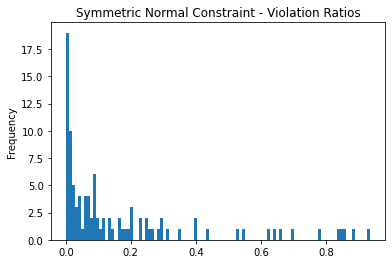

In [138]:
invConstDF3.sort_values(by=['violation_ratio'],ascending=False)['violation_ratio'].plot.hist(bins=100).set_title("Symmetric Normal Constraint - Violation Ratios")

In [139]:
pd.concat([invConstDF1, invConstDF2, invConstDF3]).to_csv('../../allConstraintsAnalysis_WRemoved_Final/invConstDFAnalysis.csv')

### Find out time required

In [ ]:
import pandas as pd
import os
from tqdm.notebook import tqdm

codepConstViolations = {}

codepConstViolations = {}
codepConstPropList = set()

def extractTimes(filename):
    times = []
    with open(filename) as f:
        for line in f:
            if "real" in line:
                line = line.strip()
                time1 = line.split("\t")[1]
                mins, sec = time1.split("m")
                mins = int(mins)
                sec = float(sec[:-1])
                times.append(60 * mins + sec)
    return times

# codepConstViolationsSummary = {}
times = []
filePath = '/data/wd-correctness/propertiesSplit_WRemoved_Final/checkViolations/exec_logs/'
for filename in tqdm(os.listdir(filePath)):
    if filename.startswith("invConst_Validator"):
        tempTimes = extractTimes(filePath + filename)
        times += tempTimes

In [ ]:
print(pd.Series(times).describe())

In [ ]:
import seaborn as sns
sns.lineplot(data=pd.Series(times)).set_title("Distribution of times (in s) taken for symmetric constraint checks")

# Combine Plots for constraints

In [30]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

typeConstDF = pd.read_csv("../../allConstraintsAnalysis_WRemoved_Final/typeConstDFAnalysis.csv")
typeConstDF = typeConstDF.set_index(typeConstDF.iloc[:, 0])

valTypeConstDF = pd.read_csv("../../allConstraintsAnalysis_WRemoved_Final/valueTypeConstDFAnalysis.csv")
valTypeConstDF = valTypeConstDF.set_index(valTypeConstDF.iloc[:, 0])

codepConstDF1 = pd.read_csv("../../allConstraintsAnalysis_WRemoved_Final/codepConstDFAnalysis.csv")
codepConstDF1 = codepConstDF1.set_index(codepConstDF1.iloc[:, 0])

symmConstDF = pd.read_csv("../../allConstraintsAnalysis_WRemoved_Final/symmConstDFAnalysis.csv")
symmConstDF = symmConstDF.set_index(symmConstDF.iloc[:, 0])

invConstDF = pd.read_csv("../../allConstraintsAnalysis_WRemoved_Final/invConstDFAnalysis.csv")
invConstDF = invConstDF.set_index(invConstDF.iloc[:, 0])

In [3]:
typeConstDF1 = typeConstDF.add_suffix("_type_const")['violation_ratio_type_const'].rename().sort_values()

In [4]:
valTypeConstDF1 = valTypeConstDF.add_suffix("_valuetype_const")['violation_ratio_valuetype_const'].sort_values()

In [5]:
codepConstDF1_1 = codepConstDF1.add_suffix("_codep_const")['violation_ratio_codep_const'].sort_values()

In [6]:
symmConstDF1_1 = symmConstDF.add_suffix("_symm_const")['violation_ratio_symm_const'].sort_values()

In [7]:
invConstDF1_1 = invConstDF.add_suffix("_inv_const")['violation_ratio_inv_const'].sort_values()

In [8]:
typeConstDF1.index.names = ['property']
typeConstDF1 = typeConstDF1.reset_index().reset_index()
typeConstDF1['index'] = typeConstDF1['index'].apply(lambda p: (p+1) * 100/len(typeConstDF1))
typeConstDF1 = typeConstDF1.set_index('index')[0]

In [9]:
valTypeConstDF1.index.names = ['property']
valTypeConstDF1 = valTypeConstDF1.reset_index().reset_index()
valTypeConstDF1['index'] = valTypeConstDF1['index'].apply(lambda p: (p+1) * 100/len(valTypeConstDF1))
valTypeConstDF1 = valTypeConstDF1.set_index('index')['violation_ratio_valuetype_const']

In [10]:
codepConstDF1_1.index.names = ['property']
codepConstDF1_1 = codepConstDF1_1.reset_index().reset_index()
codepConstDF1_1['index'] = codepConstDF1_1['index'].apply(lambda p: (p+1) * 100/len(codepConstDF1_1))
codepConstDF1_1 = codepConstDF1_1.set_index('index')['violation_ratio_codep_const']

In [11]:
symmConstDF1_1.index.names = ['property']
symmConstDF1_1 = symmConstDF1_1.reset_index().reset_index()
symmConstDF1_1['index'] = symmConstDF1_1['index'].apply(lambda p: (p+1) * 100/len(symmConstDF1_1))
symmConstDF1_1 = symmConstDF1_1.set_index('index')['violation_ratio_symm_const']

In [12]:
invConstDF1_1.index.names = ['property']
invConstDF1_1 = invConstDF1_1.reset_index().reset_index()
invConstDF1_1['index'] = invConstDF1_1['index'].apply(lambda p: (p+1) * 100/len(invConstDF1_1))
invConstDF1_1 = invConstDF1_1.set_index('index')['violation_ratio_inv_const']

In [23]:
typeConstDF2 = [np.percentile(typeConstDF1,i)*100 for i in range(1, 101)]
valTypeConstDF2 = [np.percentile(valTypeConstDF1,i)*100 for i in range(1, 101)]
codepConstDF1_2 = [np.percentile(codepConstDF1_1,i)*100 for i in range(1, 101)]
symmConstDF1_2 = [np.percentile(symmConstDF1_1,i)*100 for i in range(1, 101)]
invConstDF1_2 = [np.percentile(invConstDF1_1,i)*100 for i in range(1, 101)]

In [24]:
constAnalysisDF = pd.DataFrame({'index':list(range(1, 101)), 'type': typeConstDF2, 'value type': valTypeConstDF2, 'irs': codepConstDF1_2, 'symmetric': symmConstDF1_2, 'inverse': invConstDF1_2})

In [25]:
constAnalysisDF = constAnalysisDF.melt('index', var_name='constraint',  value_name='VR')

In [26]:
constAnalysisDF.head()

index constraint   VR
0      1       type  0.0
1      2       type  0.0
2      3       type  0.0
3      4       type  0.0
4      5       type  0.0

[Text(0.5, 0, 'Proportion of properties (in %)'),
 Text(0, 0.5, 'Violation Ratio (in %)')]

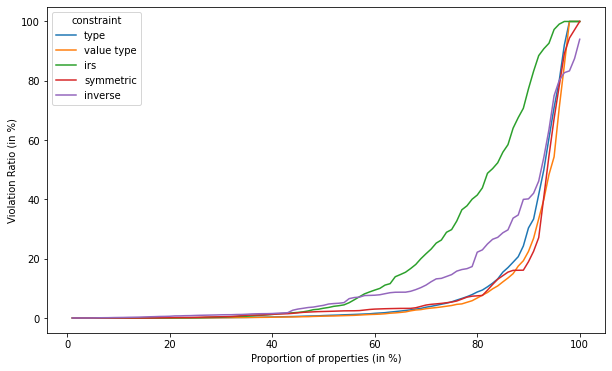

In [33]:
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x='index', y='VR', hue='constraint', data=constAnalysisDF)
ax.set(xlabel="Proportion of properties (in %)", ylabel = "Violation Ratio (in %)")

Fin.